(bayes_np_causal)=
# Bayesian Non-parametric Causal Inference

:::{post} January, 2024
:tags: bart, propensity scores, dirichlet process regression  
:category: advanced, reference
:author: Nathaniel Forde
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

### NHEFS Data

In [3]:
nhefs_df = pd.read_csv("../data/nhefs.csv")
nhefs_df.head()

age  race  sex  smokeintensity  smokeyrs   wt71  active_1  active_2  \
0   42     1    0              30        29  79.04         0         0   
1   36     0    0              20        24  58.63         0         0   
2   56     1    1              20        26  56.81         0         0   
3   68     1    0               3        53  59.42         1         0   
4   40     0    0              20        19  87.09         1         0   

   education_2  education_3  education_4  education_5  exercise_1  exercise_2  \
0            0            0            0            0           0           1   
1            1            0            0            0           0           0   
2            1            0            0            0           0           1   
3            0            0            0            0           0           1   
4            1            0            0            0           1           0   

   age^2     wt71^2  smokeintensity^2  smokeyrs^2  trt    outcome  
0   1764  6247.3216               900         841    0 -10.093960  
1   1296  3437.4769               400         576    0   2.604970  
2   3136  3227.3761               400         676    0   9.414486  
3   4624  3530.7364                 9        2809    0   4.990117  
4   1600  7584.6681               400         361    0   4.989251

In [227]:
X = nhefs_df.copy()
y = nhefs_df["outcome"]
t = nhefs_df["trt"]
X = X.drop(["trt", "outcome"], axis=1)
X.head()

age  race  sex  smokeintensity  smokeyrs   wt71  active_1  active_2  \
0   42     1    0              30        29  79.04         0         0   
1   36     0    0              20        24  58.63         0         0   
2   56     1    1              20        26  56.81         0         0   
3   68     1    0               3        53  59.42         1         0   
4   40     0    0              20        19  87.09         1         0   

   education_2  education_3  education_4  education_5  exercise_1  exercise_2  \
0            0            0            0            0           0           1   
1            1            0            0            0           0           0   
2            1            0            0            0           0           1   
3            0            0            0            0           0           1   
4            1            0            0            0           1           0   

   age^2     wt71^2  smokeintensity^2  smokeyrs^2  
0   1764  6247.3216               900         841  
1   1296  3437.4769               400         576  
2   3136  3227.3761               400         676  
3   4624  3530.7364                 9        2809  
4   1600  7584.6681               400         361

### Propensity Score Model

In [204]:
def make_propensity_model(X, t, bart=True, probit=True, samples=1000):
    coords = {"coeffs": list(X.columns), "obs": range(len(X))}
    with pm.Model(coords=coords) as model_ps:
        if bart:
            mu = pmb.BART("mu", X, t)
            if probit:
                p = pm.Deterministic("p", pm.math.invprobit(mu))
            else:
                p = pm.Deterministic("p", pm.math.invlogit(mu))
        else:
            b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
            mu = pm.math.dot(X, b)
            p = pm.Deterministic("p", pm.math.invlogit(mu))

        t_pred = pm.Bernoulli("t_pred", p=p, observed=t, dims="obs")

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(samples, idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    return model_ps, idata


m_ps_logit, idata_logit = make_propensity_model(X, t, bart=False, samples=1000)

Sampling: [b, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
Sampling: [t_pred]


In [174]:
pm.model_to_graphviz(m_ps_logit)

In [208]:
m_ps_probit, idata_probit = make_propensity_model(X, t, bart=True, probit=False, samples=4000)

Sampling: [mu, t_pred]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 92 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [t_pred]


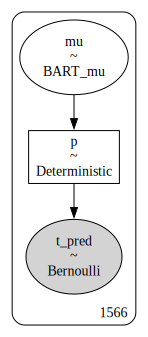

In [903]:
pm.model_to_graphviz(m_ps_probit)

In [1111]:
idata_logit

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [117]:
az.plot_forest(
    [idata_logit, idata_probit],
    var_names=["p"],
    coords={"p_dim_0": range(30)},
    figsize=(10, 20),
    combined=True,
    kind="ridgeplot",
    model_names=["Logistic Regression", "BART"],
    r_hat=True,
    ridgeplot_alpha=0.4,
);

In [119]:
ps_logit = idata_logit["posterior"]["p"].mean(dim=("chain", "draw")).round(2)
ps_logit

<xarray.DataArray 'p' (p_dim_0: 1566)>
array([0.1 , 0.15, 0.13, ..., 0.13, 0.47, 0.18])
Coordinates:
  * p_dim_0  (p_dim_0) int64 0 1 2 3 4 5 6 ... 1560 1561 1562 1563 1564 1565

In [120]:
ps_probit = idata_probit["posterior"]["p"].mean(dim=("chain", "draw")).round(2)
ps_probit

<xarray.DataArray 'p' (p_dim_0: 1566)>
array([0.16, 0.16, 0.18, ..., 0.19, 0.36, 0.21])
Coordinates:
  * p_dim_0  (p_dim_0) int64 0 1 2 3 4 5 6 ... 1560 1561 1562 1563 1564 1565

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
axs[0].hist(ps_logit, ec="black", color="slateblue")
axs[1].hist(ps_probit, ec="black", color="skyblue")
axs[0].set_title("Propensity Scores under Logistic Regression")
axs[1].set_title("Propensity Scores under Non-Parametric BART model \n with probit transform");

### Estimated Expected Causal Effect (ATE)

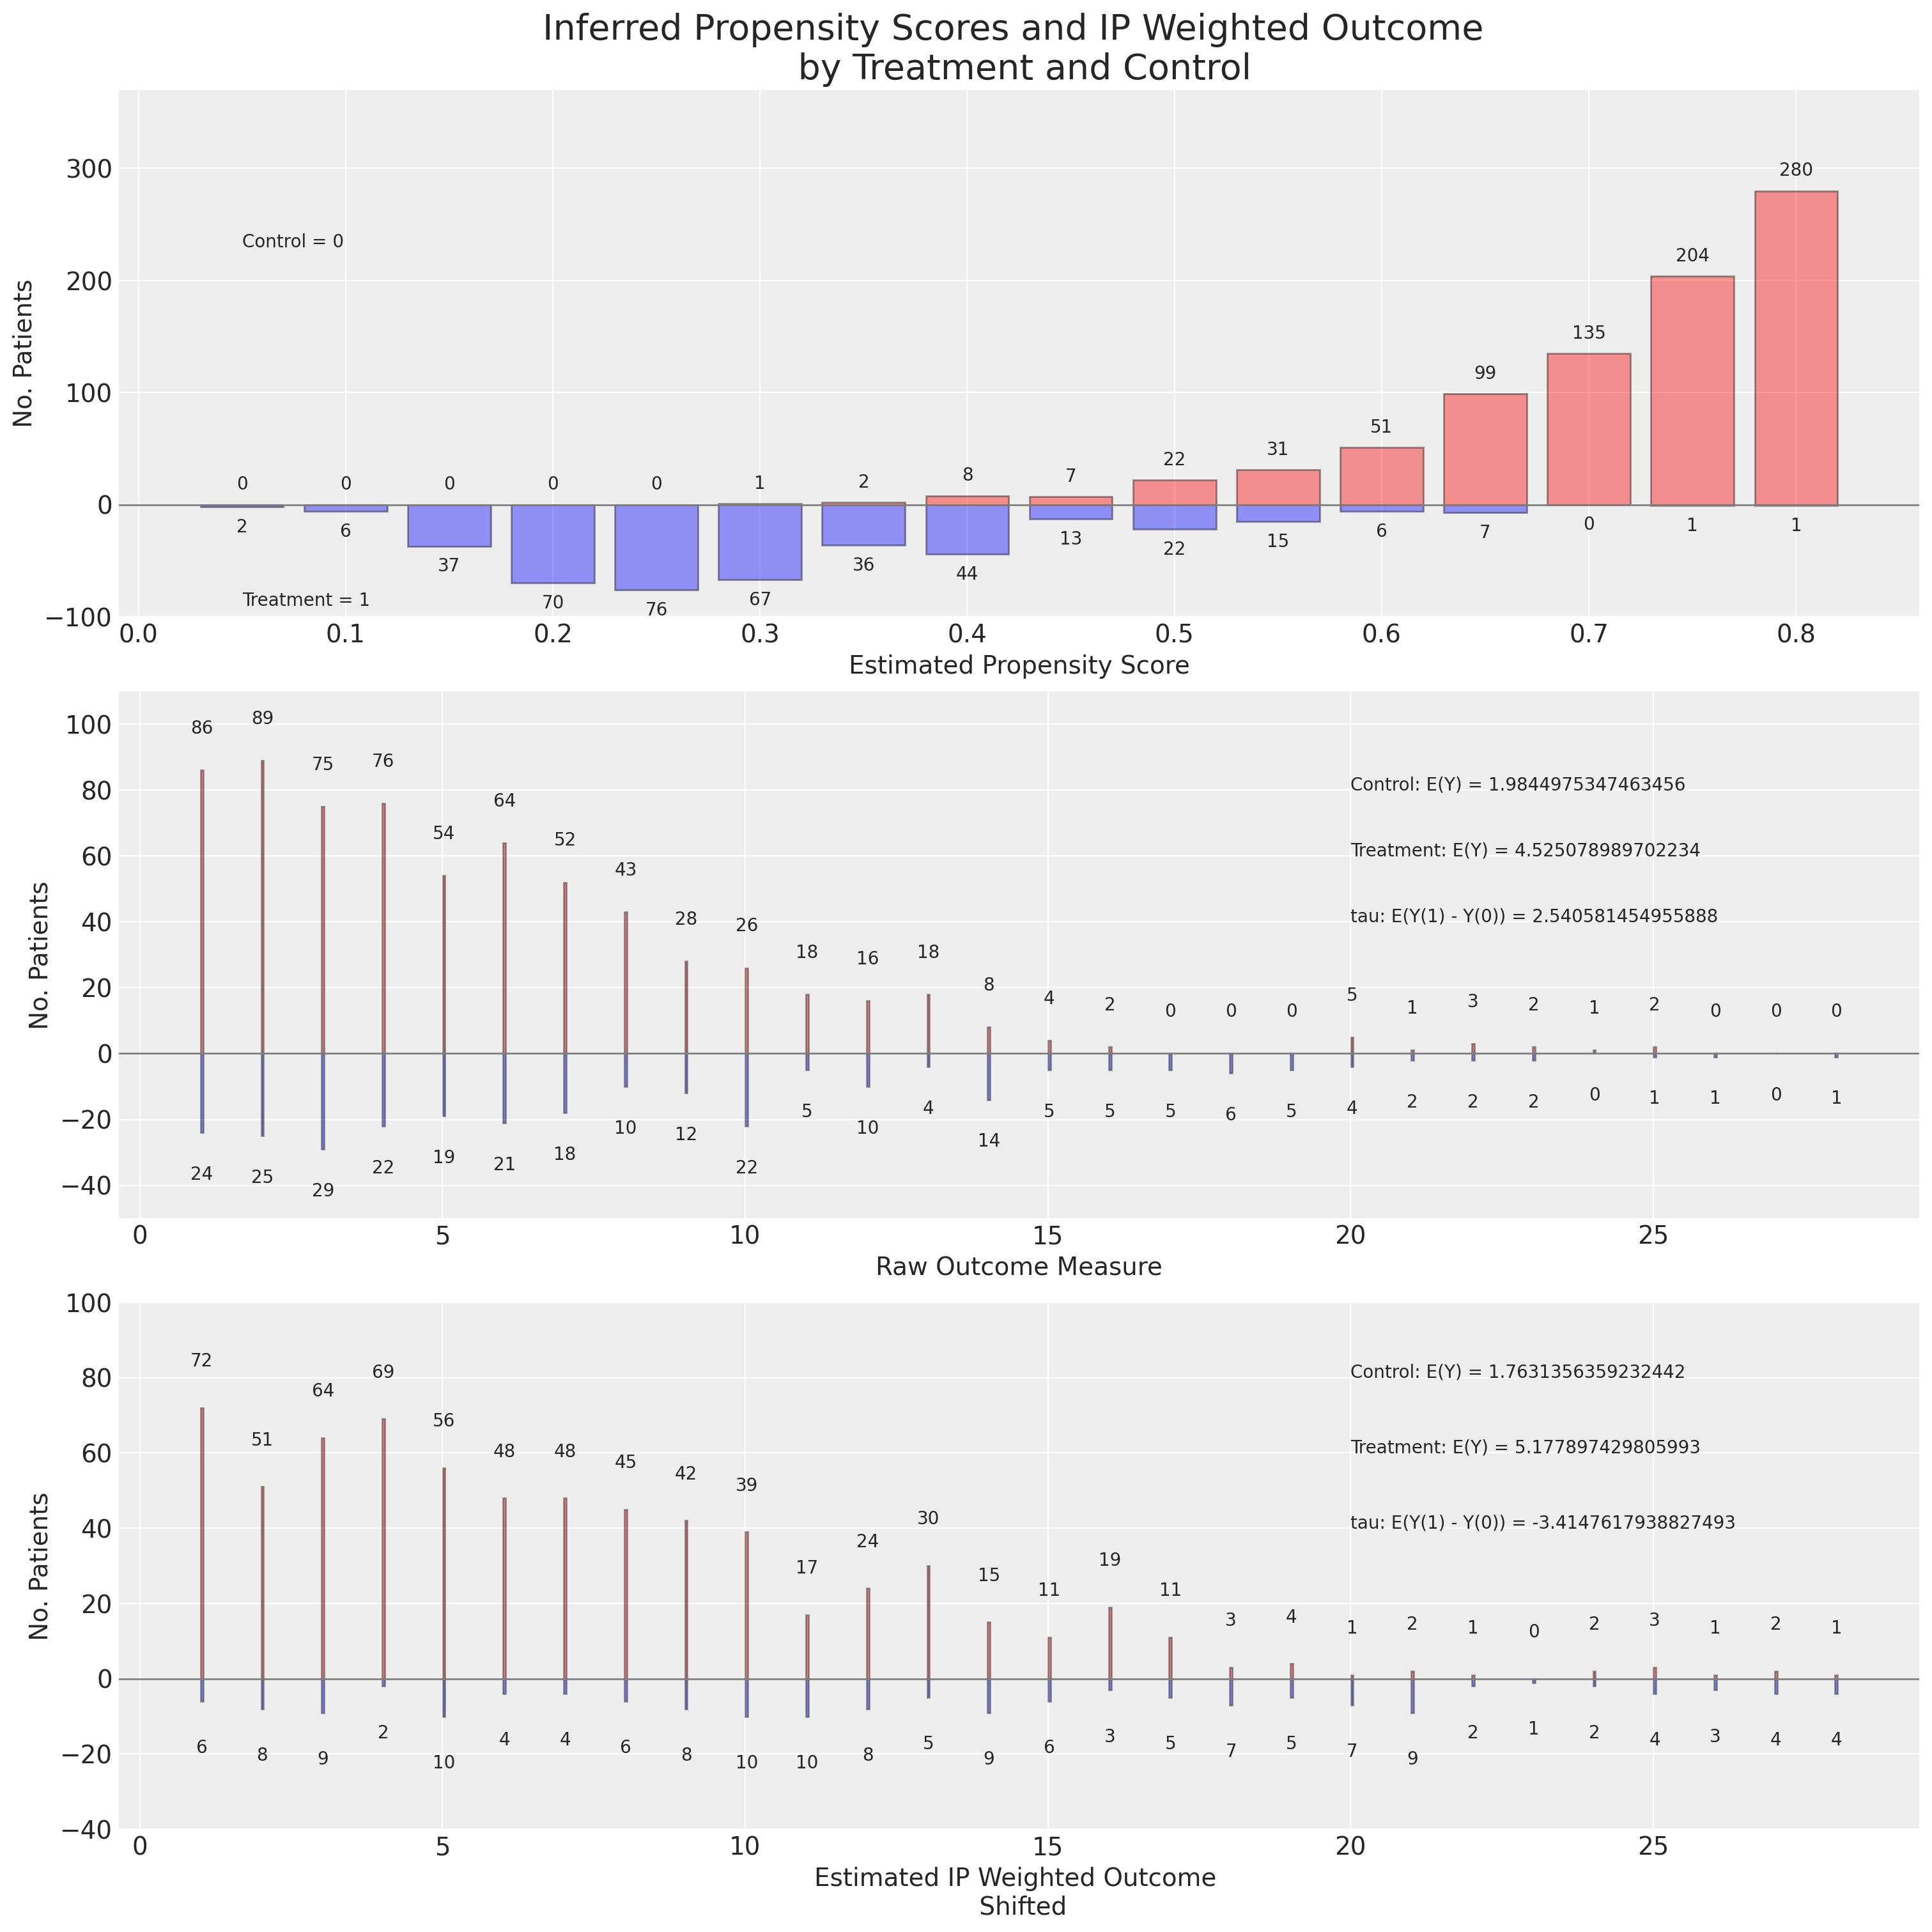

In [228]:
def plot_weights(bins, top0, top1, ylim, ax):
    ax.axhline(0, c="gray", linewidth=1)
    ax.set_ylim(ylim)
    bars0 = ax.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor="red", alpha=0.4)
    bars1 = ax.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor="blue", alpha=0.4)

    for bars in (bars0, bars1):
        for bar in bars:
            bar.set_edgecolor("black")

    for x, y in zip(bins, top0):
        ax.text(x + 0.025, y + 10, str(y), ha="center", va="bottom")

    for x, y in zip(bins, top1):
        ax.text(x + 0.025, -y - 10, str(y), ha="center", va="top")


def make_plot(
    X,
    idata,
    lower_bins=np.arange(1, 30, 1),
    ylims=[
        (-100, 370),
        (
            -40,
            100,
        ),
        (-50, 110),
    ],
    text_pos=(20, 80),
    ps=None,
):
    X = X.copy()
    if ps is None:
        X["ps"] = idata["posterior"]["p"].mean(dim=("chain", "draw")).values
    else:
        X["ps"] = ps
    X["trt"] = t
    X["ps"] = np.where(X["trt"], X["ps"], 1 - X["ps"])
    X["i_ps"] = 1 / X["ps"]
    X["log_y"] = y

    bins = np.arange(0.025, 0.85, 0.05)
    propensity0 = X[X["trt"] == 0]["ps"]
    propensity1 = X[X["trt"] == 1]["ps"]
    top0, _ = np.histogram(propensity0, bins=bins)
    top1, _ = np.histogram(propensity1, bins=bins)

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    axs = axs.flatten()

    plot_weights(bins, top0, top1, ylims[0], axs[0])
    axs[0].text(0.05, 230, "Control = 0")
    axs[0].text(0.05, -90, "Treatment = 1")

    axs[0].set_ylabel("No. Patients", fontsize=14)
    axs[0].set_xlabel("Estimated Propensity Score", fontsize=14)
    axs[0].set_title(
        "Inferred Propensity Scores and IP Weighted Outcome \n by Treatment and Control",
        fontsize=20,
    )

    bins = lower_bins
    i_propensity0 = X[X["trt"] == 0]["i_ps"]
    i_propensity1 = X[X["trt"] == 1]["i_ps"]
    outcome_trt = X[X["trt"] == 1]["log_y"]
    outcome_ntrt = X[X["trt"] == 0]["log_y"]
    propensity0 = i_propensity0 * outcome_ntrt
    propensity1 = i_propensity1 * outcome_trt

    top0, _ = np.histogram(propensity0, bins=bins)
    top1, _ = np.histogram(propensity1, bins=bins)
    plot_weights(bins, top0, top1, ylims[1], axs[2])
    axs[2].set_ylabel("No. Patients", fontsize=14)
    axs[2].set_xlabel("Estimated IP Weighted Outcome \n Shifted", fontsize=14)
    axs[2].text(text_pos[0], text_pos[1], f"Control: E(Y) = {propensity0.sum() / len(X)}")
    axs[2].text(text_pos[0], text_pos[1] - 20, f"Treatment: E(Y) = {propensity1.sum() / len(X)}")
    axs[2].text(
        text_pos[0],
        text_pos[1] - 40,
        f"tau: E(Y(1) - Y(0)) = {propensity0.sum() / len(X) - propensity1.sum() / len(X)}",
    )

    top0, _ = np.histogram(outcome_ntrt, bins=bins)
    top1, _ = np.histogram(outcome_trt, bins=bins)
    plot_weights(bins, top0, top1, ylims[2], axs[1])
    axs[1].set_ylabel("No. Patients", fontsize=14)
    axs[1].set_xlabel("Raw Outcome Measure", fontsize=14)
    axs[1].text(text_pos[0], text_pos[1], f"Control: E(Y) = {outcome_ntrt.mean()}")
    axs[1].text(text_pos[0], text_pos[1] - 20, f"Treatment: E(Y) = {outcome_trt.mean()}")
    axs[1].text(
        text_pos[0],
        text_pos[1] - 40,
        f"tau: E(Y(1) - Y(0)) = {outcome_trt.mean() - outcome_ntrt.mean()}",
    )


make_plot(X, idata_logit)

In [125]:
def get_ate(X, t, y, i, idata):
    X = X.copy()
    X["ps"] = idata["posterior"]["p"].stack(z=("chain", "draw"))[:, i].values
    X["trt"] = t
    X["ps"] = np.where(X["trt"], X["ps"], 1 - X["ps"])
    X["i_ps"] = 1 / X["ps"]
    X["outcome"] = y
    i_propensity0 = X[X["trt"] == 0]["i_ps"]
    i_propensity1 = X[X["trt"] == 1]["i_ps"]
    outcome_trt = X[X["trt"] == 1]["outcome"]
    outcome_ntrt = X[X["trt"] == 0]["outcome"]
    weighted_outcome_ntrt = i_propensity0 * outcome_ntrt
    weighted_outcome_trt = i_propensity1 * outcome_trt
    ntrt = weighted_outcome_ntrt.sum() / len(X)
    trt = weighted_outcome_trt.sum() / len(X)
    ate = ntrt - trt
    return [ate, trt, ntrt]


qs = range(4000)
ate_dist = [get_ate(X, t, y, q, idata_logit) for q in qs]

ate_dist_df_logit = pd.DataFrame(ate_dist, columns=["ATE", "E(Y(1))", "E(Y(0))"])
ate_dist_df_logit.head()

ATE   E(Y(1))   E(Y(0))
0 -2.922743  4.835590  1.912847
1 -3.921811  5.662931  1.741120
2 -4.043571  5.837457  1.793886
3 -3.873229  5.576668  1.703438
4 -3.218534  5.083996  1.865462

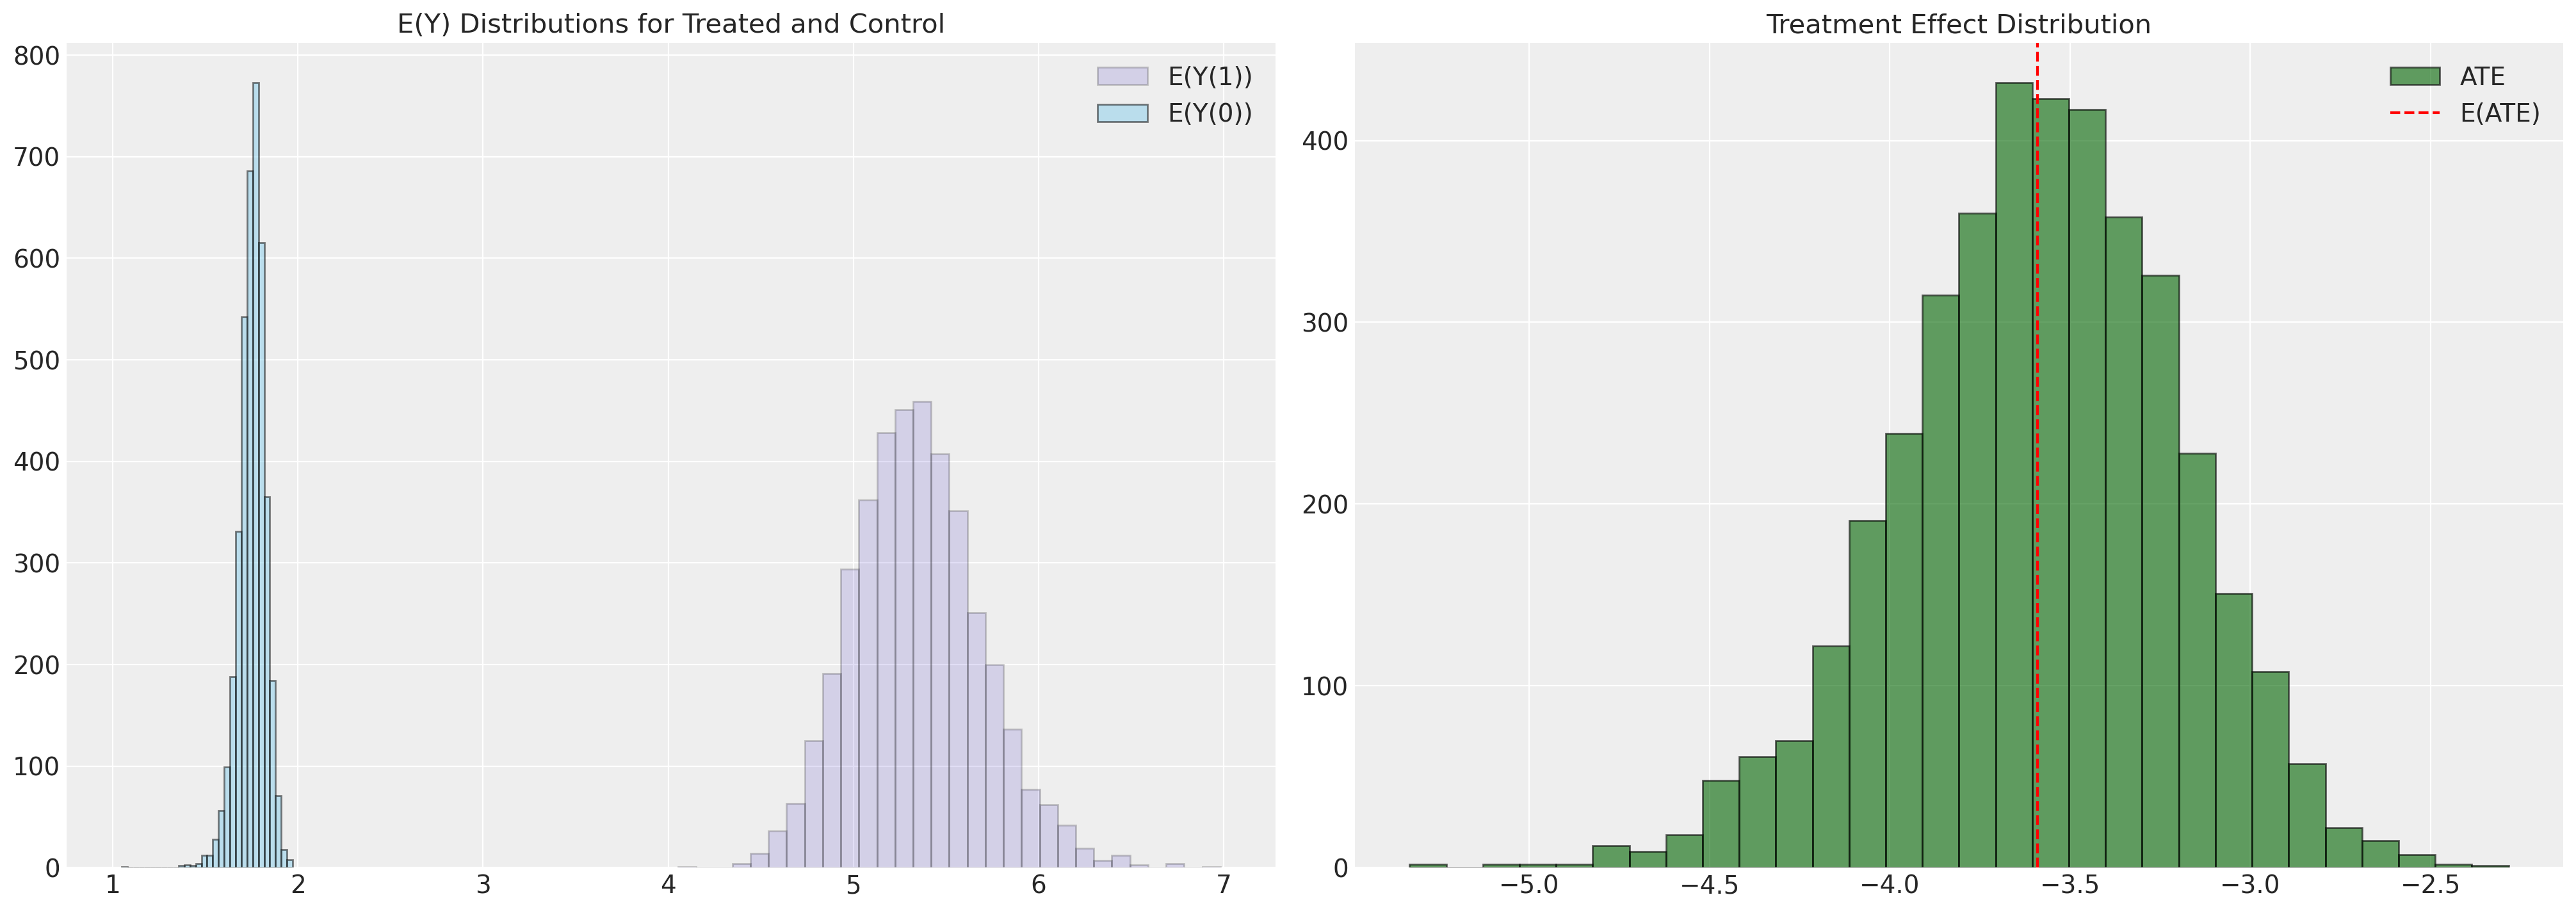

In [126]:
def plot_ate(ate_dist_df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    axs[0].hist(
        ate_dist_df["E(Y(1))"], bins=30, ec="black", color="slateblue", label="E(Y(1))", alpha=0.2
    )
    axs[0].hist(
        ate_dist_df["E(Y(0))"], bins=30, ec="black", color="skyblue", label="E(Y(0))", alpha=0.5
    )
    axs[1].hist(ate_dist_df["ATE"], bins=30, ec="black", color="darkgreen", label="ATE", alpha=0.6)
    axs[1].axvline(ate_dist_df["ATE"].mean(), label="E(ATE)", linestyle="--", color="red")
    axs[0].set_title("E(Y) Distributions for Treated and Control", fontsize=15)
    axs[1].set_title("Treatment Effect Distribution", fontsize=15)
    axs[1].legend()
    axs[0].legend()


plot_ate(ate_dist_df_logit)

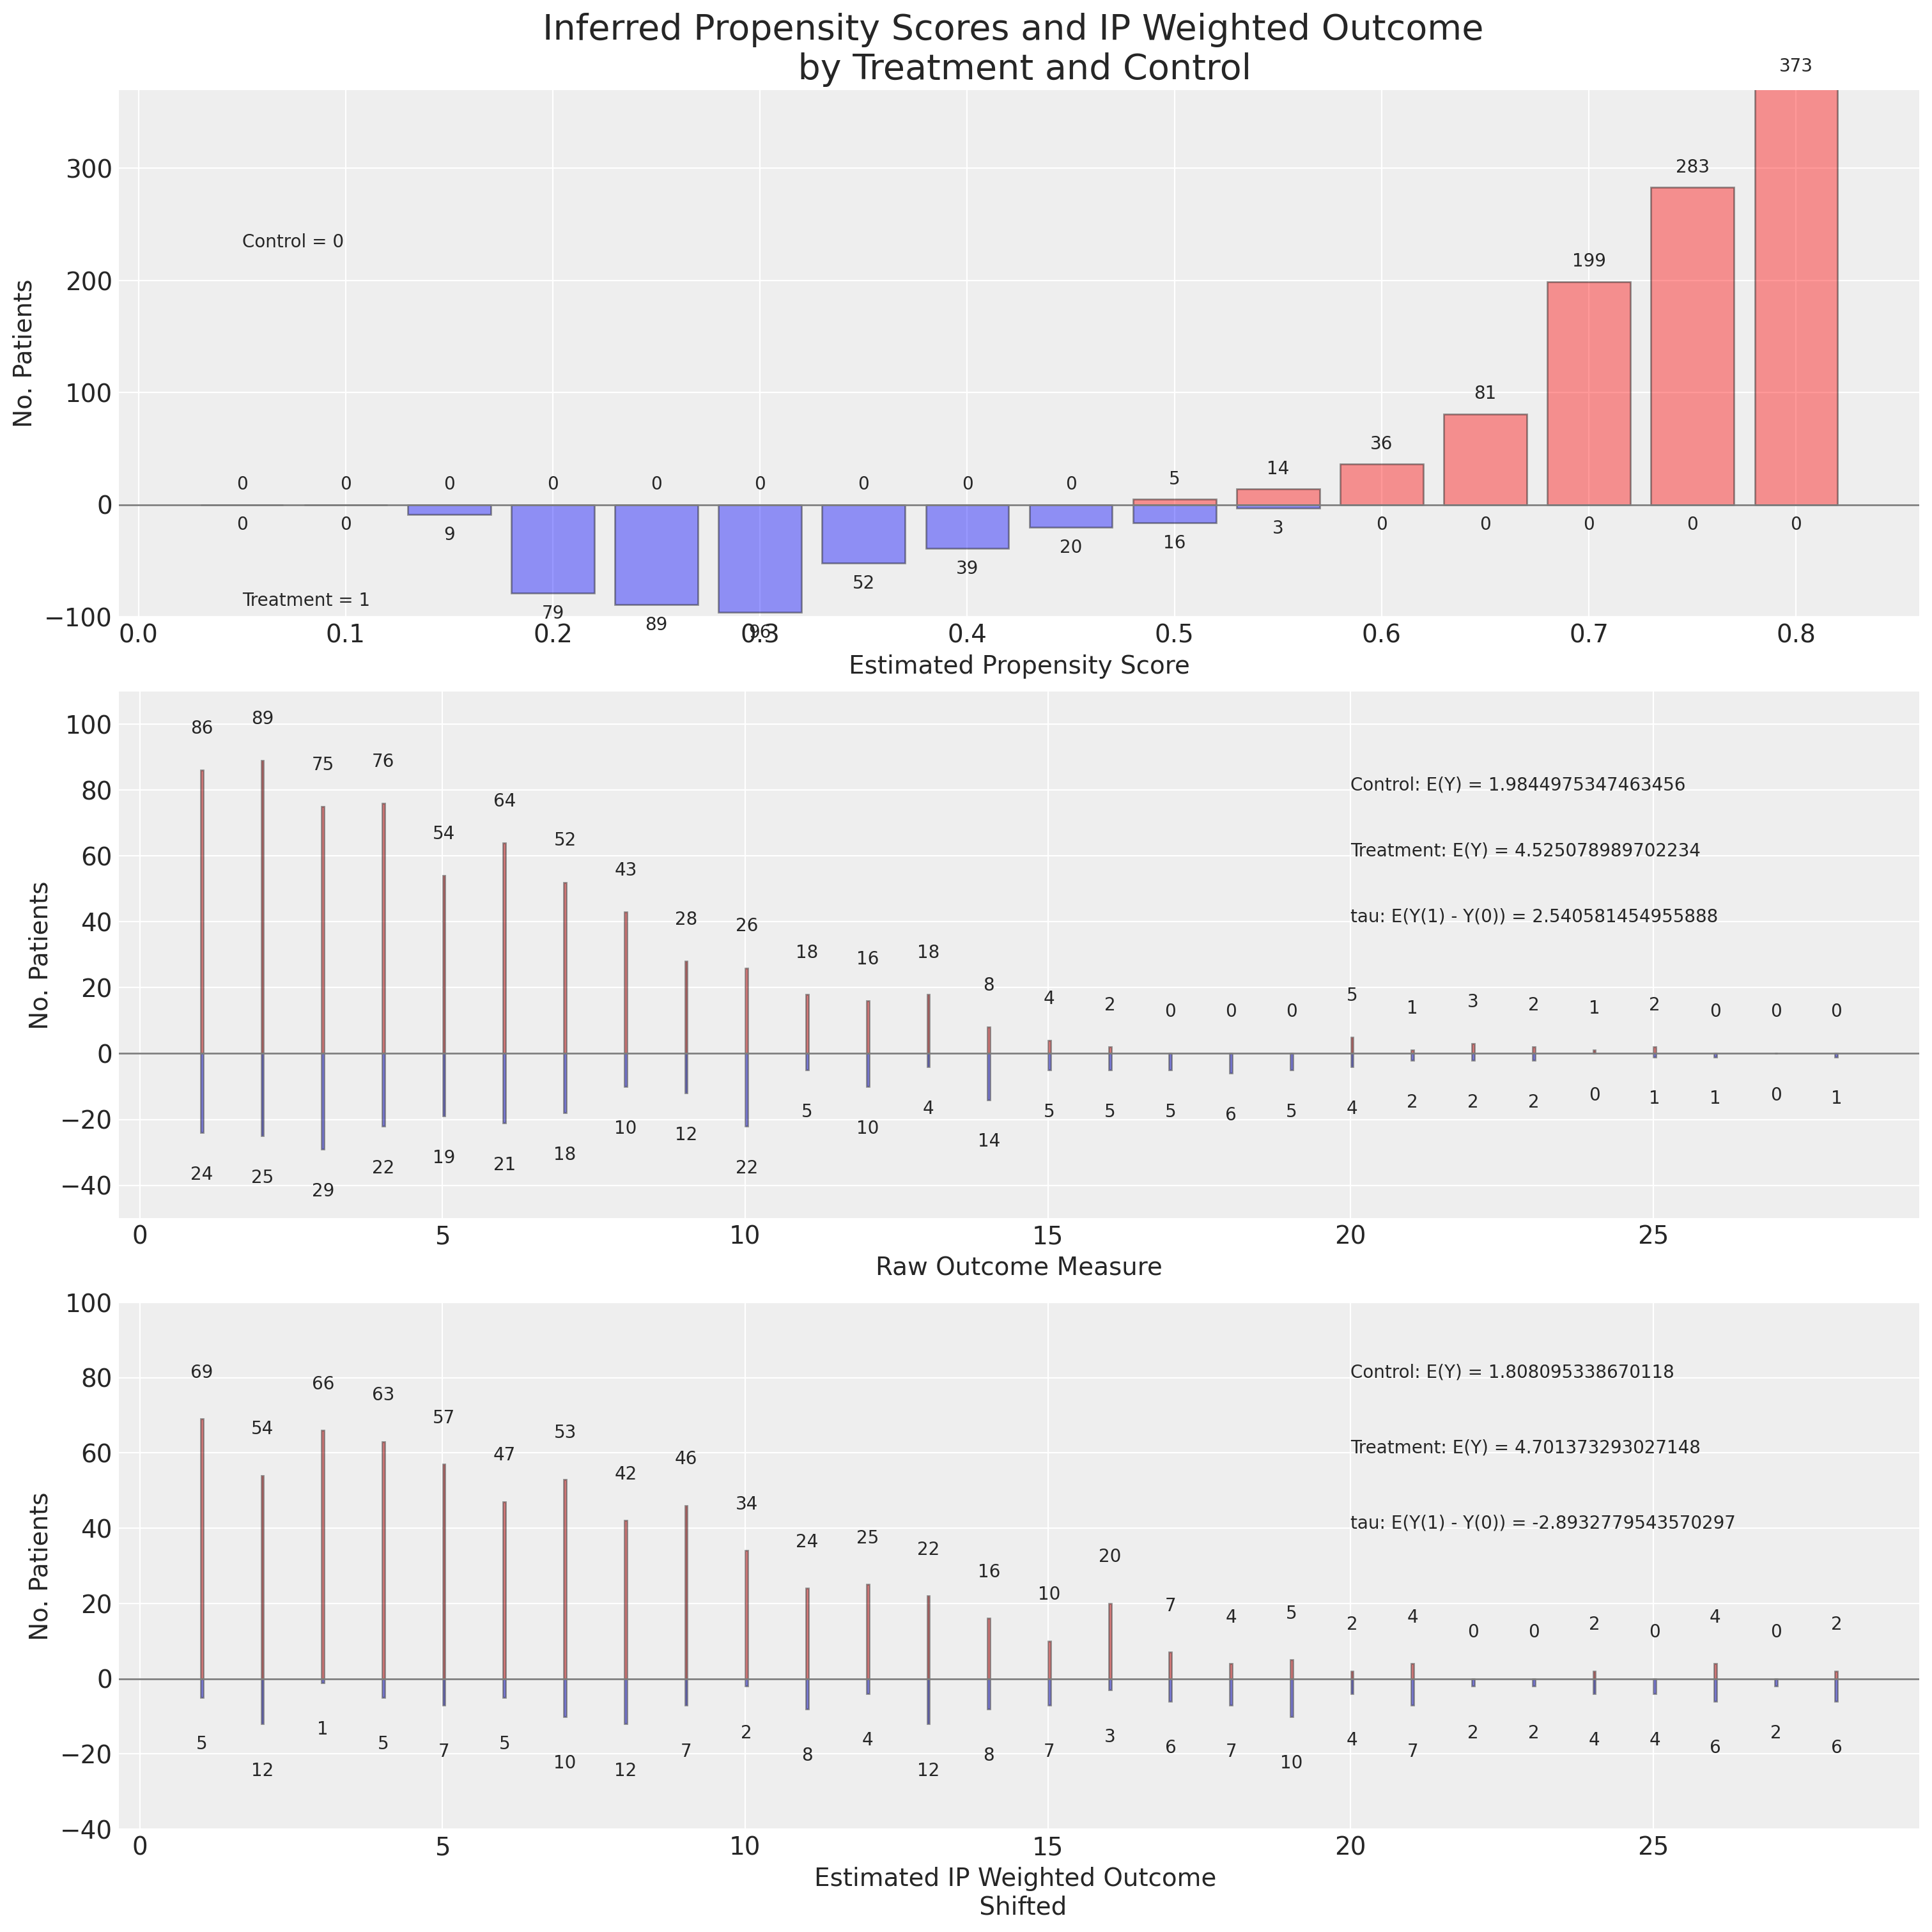

In [229]:
make_plot(X, idata_probit)

In [183]:
ate_dist_probit = [get_ate(X, t, y, q, idata_probit) for q in qs]
ate_dist_df_probit = pd.DataFrame(ate_dist_probit, columns=["ATE", "E(Y(1))", "E(Y(0))"])
ate_dist_df_probit.head()

ATE   E(Y(1))   E(Y(0))
0 -2.521193  4.438319  1.917126
1 -2.859974  4.751459  1.891485
2 -3.489472  5.344103  1.854632
3 -4.001889  5.773710  1.771821
4 -3.457813  5.281383  1.823570

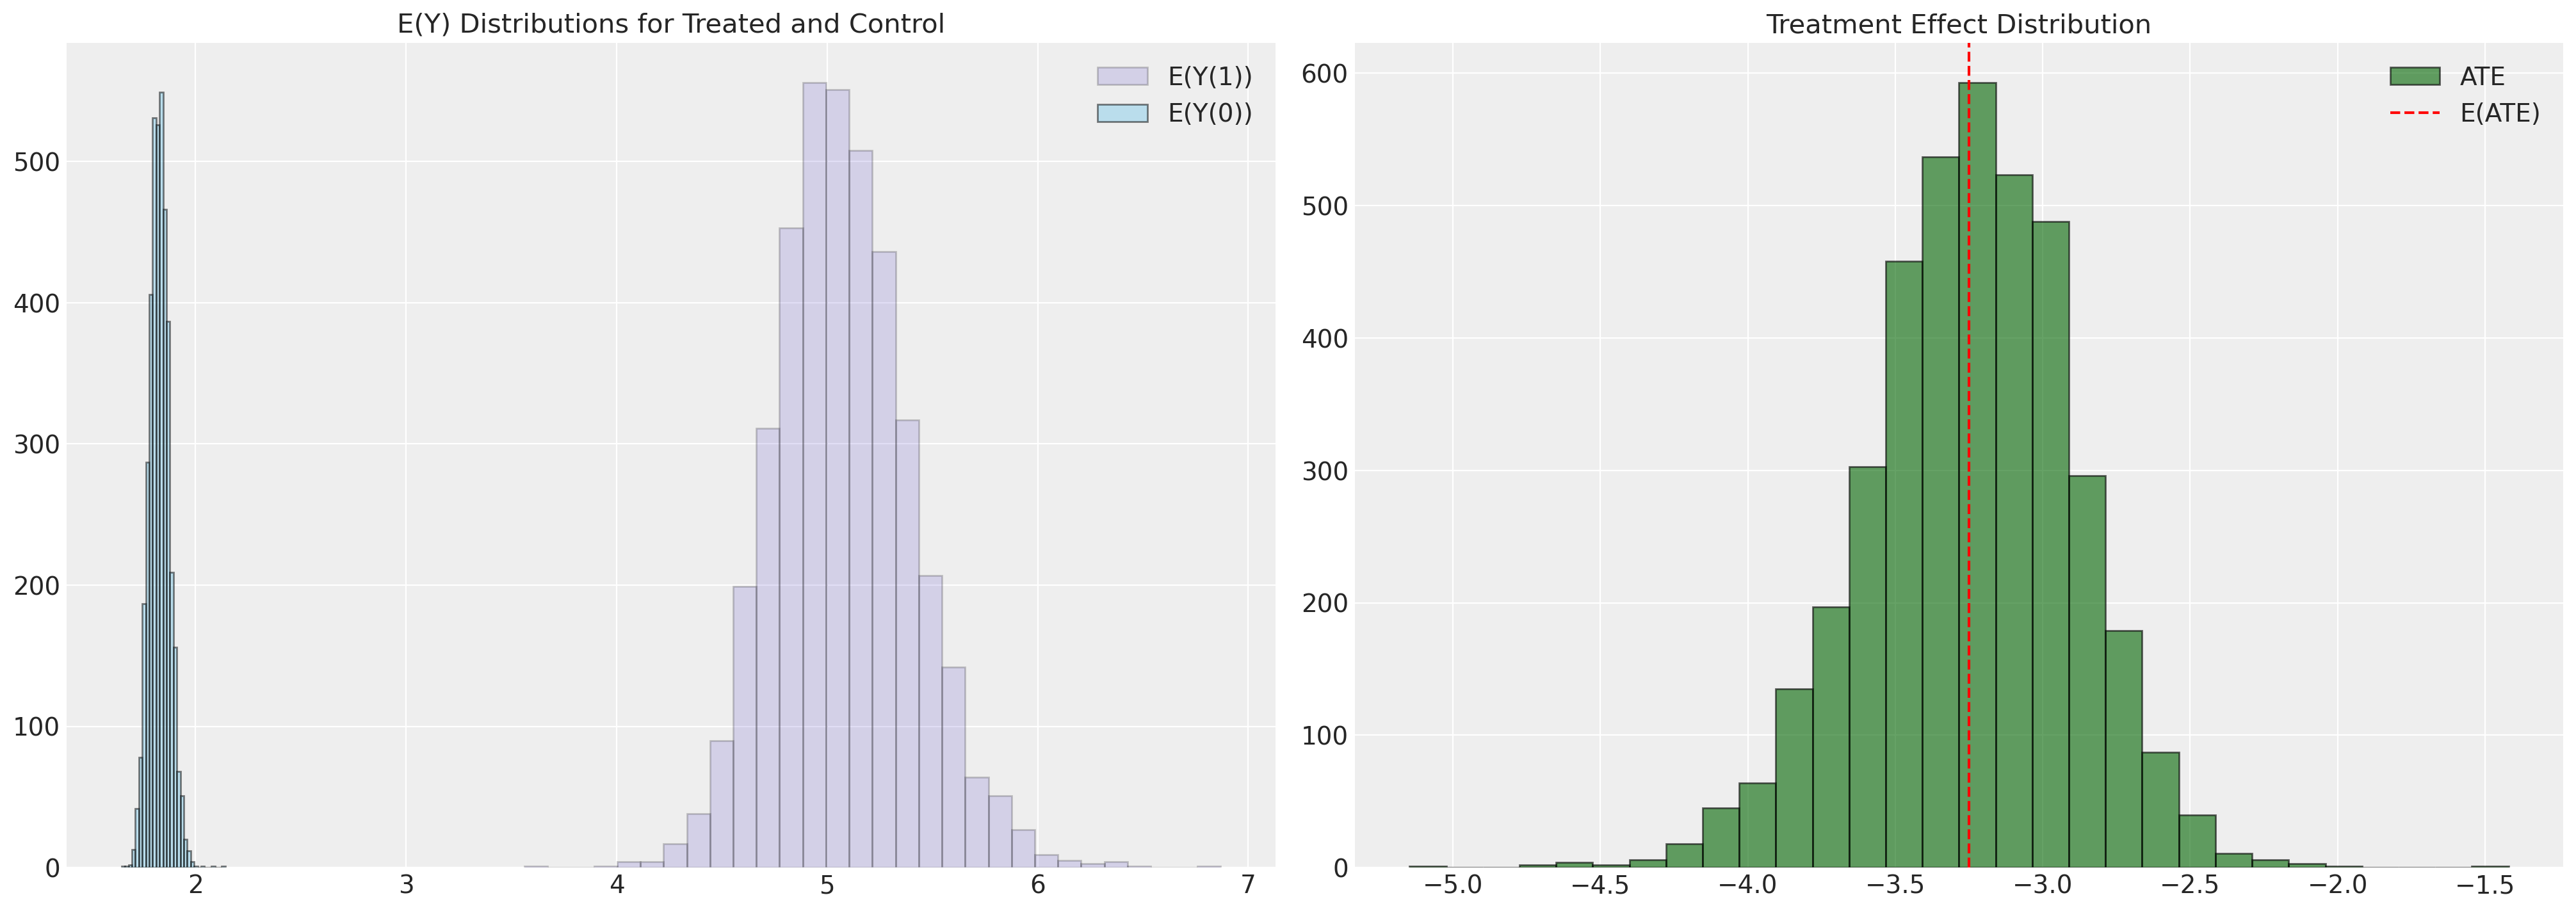

In [184]:
plot_ate(ate_dist_df_probit)

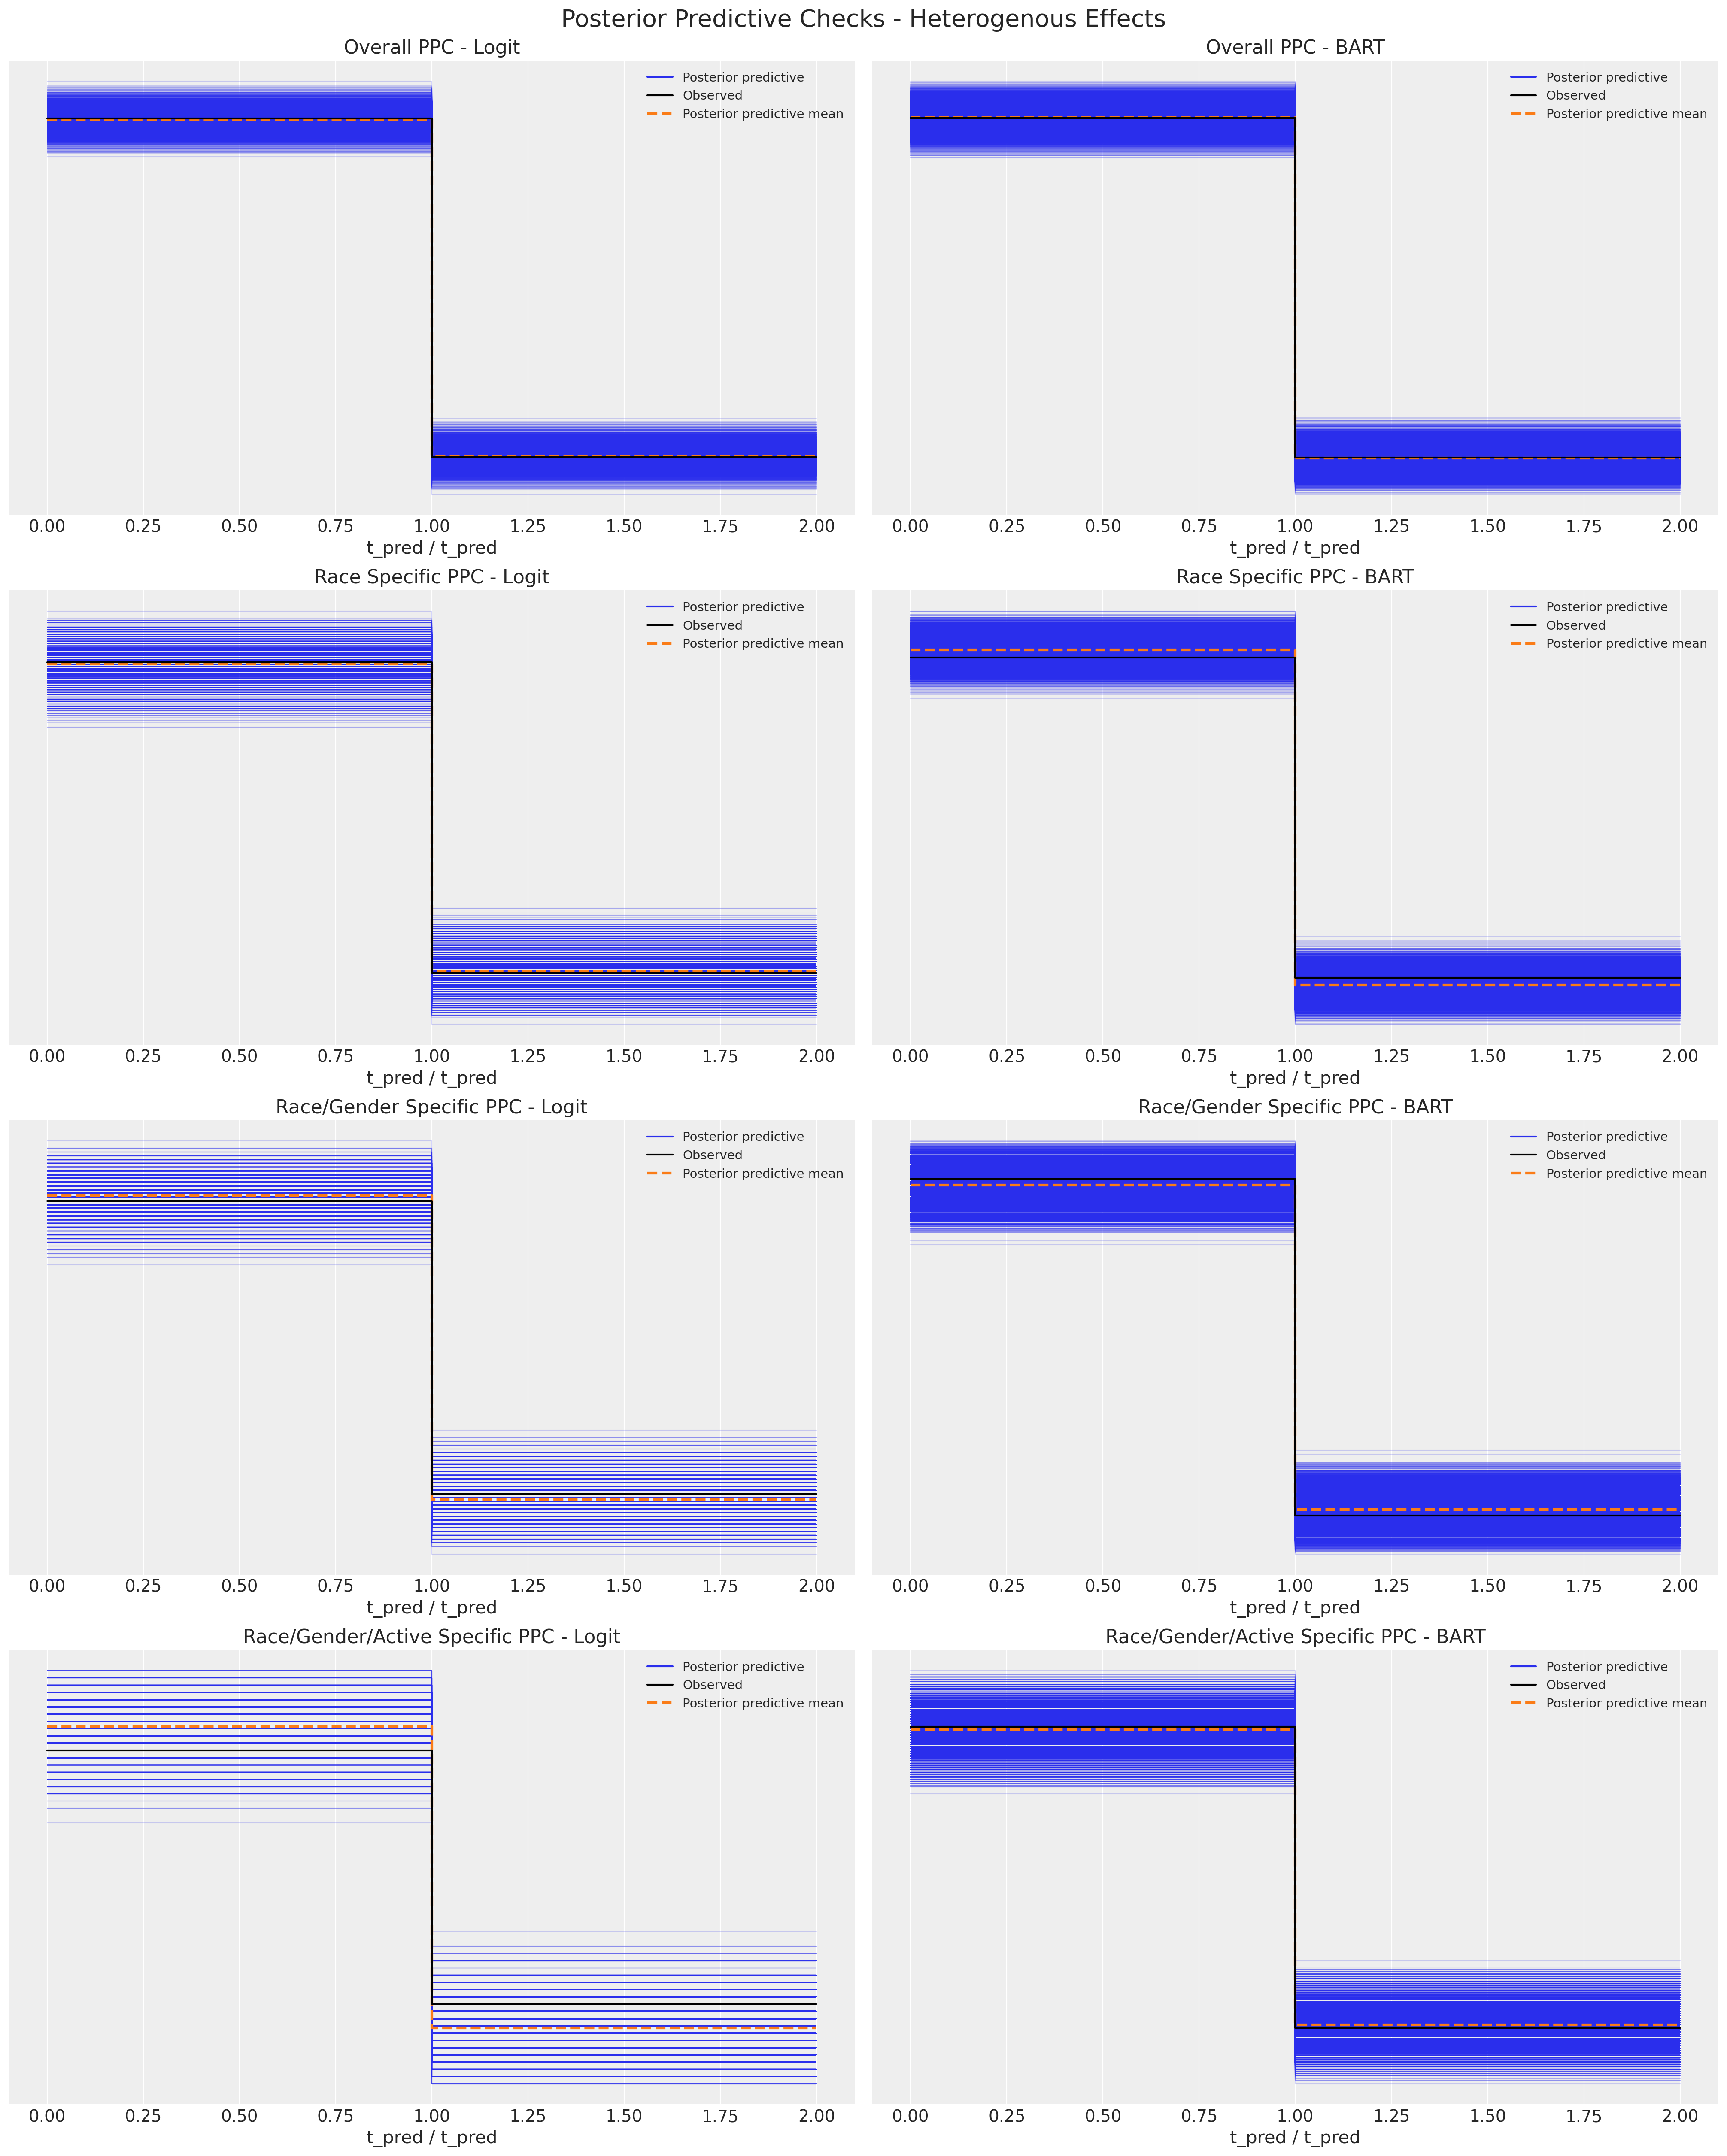

In [217]:
fig, axs = plt.subplots(4, 2, figsize=(20, 25))
axs = axs.flatten()
az.plot_ppc(idata_logit, ax=axs[0])
az.plot_ppc(idata_probit, ax=axs[1])
idx1 = list((X[X["race"] == 1].index).values)
idx0 = list((X[X["race"] == 0].index).values)
az.plot_ppc(idata_logit, ax=axs[2], coords={"obs": idx1})
az.plot_ppc(idata_probit, ax=axs[3], coords={"obs": idx0})
idx1 = list((X[(X["race"] == 1) & (X["sex"] == 1)].index).values)
idx0 = list((X[(X["race"] == 0) & (X["sex"] == 1)].index).values)
az.plot_ppc(idata_logit, ax=axs[4], coords={"obs": idx1})
az.plot_ppc(idata_probit, ax=axs[5], coords={"obs": idx0})
idx1 = list((X[(X["race"] == 1) & (X["sex"] == 1) & (X["active_1"] == 1)].index).values)
idx0 = list((X[(X["race"] == 0) & (X["sex"] == 1) & (X["active_1"] == 1)].index).values)
az.plot_ppc(idata_logit, ax=axs[6], coords={"obs": idx1})
az.plot_ppc(idata_probit, ax=axs[7], coords={"obs": idx0})
axs[0].set_title("Overall PPC - Logit")
axs[1].set_title("Overall PPC - BART")
axs[2].set_title("Race Specific PPC - Logit")
axs[3].set_title("Race Specific PPC - BART")
axs[4].set_title("Race/Gender Specific PPC - Logit")
axs[5].set_title("Race/Gender Specific PPC - BART")
axs[6].set_title("Race/Gender/Active Specific PPC - Logit")
axs[7].set_title("Race/Gender/Active Specific PPC - BART")
plt.suptitle("Posterior Predictive Checks - Heterogenous Effects", fontsize=20);

## Health Expenditure Data

In [130]:
df = pd.read_csv("../data/meps_bayes_np_health.csv", index_col=["Unnamed: 0"])
df = df[df["totexp"] > 0].reset_index(drop=True)
df["log_y"] = np.log(df["totexp"] + 1000)
df["loginc"] = np.log(df["income"])
df["smoke"] = np.where(df["smoke"] == "No", 0, 1)
df

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


age   bmi  edu  income  povlev     region     sex    marital   race  \
0       30  39.1   14   78400  343.69  Northeast    Male    Married  White   
1       53  20.2   17  180932  999.30       West    Male    Married  Multi   
2       81  21.0   14   27999  205.94       West    Male    Married  White   
3       77  25.7   12   27999  205.94       West  Female    Married  White   
4       31  23.0   12   14800   95.46      South  Female   Divorced  White   
...    ...   ...  ...     ...     ...        ...     ...        ...    ...   
16425   23  26.6   16   23000  130.72      South    Male  Separated  Asian   
16426   55  21.9   12   23000  130.72      South  Female    Married  Asian   
16427   22  -9.0    9    7000   38.66    Midwest    Male    Married  White   
16428   22  24.2   10    7000   38.66    Midwest  Female    Married  White   
16429   20  26.9   10    9858   84.24    Midwest  Female  Separated  White   

      seatbelt  smoke    phealth  totexp     log_y     loginc  
0       Always      0       Fair      40  6.946976  11.269579  
1       Always      0  Very Good     429  7.264730  12.105877  
2       Always      0  Very Good   14285  9.634627  10.239924  
3       Always      0       Fair    7959  9.100414  10.239924  
4       Always      0  Excellent    5017  8.702344   9.602382  
...        ...    ...        ...     ...       ...        ...  
16425   Always      0  Very Good     130  7.029973  10.043249  
16426   Always      0  Very Good     468  7.291656  10.043249  
16427   Always      0  Excellent     711  7.444833   8.853665  
16428   Always      0  Excellent     587  7.369601   8.853665  
16429   Always      0       Fair    1228  7.708860   9.196039  

[16430 rows x 15 columns]

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
axs = axs.flatten()
axs[0].hist(
    df[df["smoke"] == 1]["log_y"],
    alpha=0.3,
    density=True,
    bins=30,
    label="Smoker",
    ec="black",
    color="red",
)
axs[0].hist(
    df[df["smoke"] == 0]["log_y"],
    alpha=0.5,
    density=True,
    bins=30,
    label="Non-Smoker",
    ec="black",
    color="grey",
)
axs[1].hist(
    df[df["smoke"] == 1]["log_y"],
    density=True,
    bins=30,
    cumulative=True,
    histtype="step",
    label="Smoker",
    color="red",
)
axs[1].hist(
    df[df["smoke"] == 0]["log_y"],
    density=True,
    bins=30,
    cumulative=True,
    histtype="step",
    label="Non-Smoker",
    color="grey",
)
axs[2].scatter(df["loginc"], df["log_y"], c=df["smoke"], cmap="Set1", alpha=0.6)
axs[2].set_xlabel("Log Income")
axs[3].scatter(df["age"], df["log_y"], c=df["smoke"], cmap="Set1", alpha=0.6)

axs[3].set_title("Log Outcome ~ Age")
axs[2].set_title("Log Outcome ~ Log Income")
axs[3].set_xlabel("Age")
axs[0].set_title("Empirical Densities")
axs[0].legend()
axs[1].legend()
axs[1].set_title("Empirical Cumulative \n Densities");

In [132]:
qs = np.linspace(0.05, 0.99, 100)
quantile_diff = (
    df.groupby("smoke")[["totexp"]]
    .quantile(qs)
    .reset_index()
    .pivot("level_1", "smoke", "totexp")
    .rename({0: "Non-Smoker", 1: "Smoker"}, axis=1)
    .assign(diff=lambda x: x["Non-Smoker"] - x["Smoker"])
    .reset_index()
    .rename({"level_1": "quantile"}, axis=1)
)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(quantile_diff["quantile"], quantile_diff["Smoker"])
axs[0].plot(quantile_diff["quantile"], quantile_diff["Non-Smoker"])
axs[0].set_title("Q-Q plot comparing \n Smoker and Non-Smokers")
axs[1].plot(quantile_diff["quantile"], quantile_diff["diff"])
axs[1].set_title("Differences across the Quantiles");

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_26289/533968904.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  quantile_diff = (df.groupby('smoke')[['totexp']].quantile(qs).reset_index()


In [231]:
dummies = pd.concat(
    [
        pd.get_dummies(df["seatbelt"], drop_first=True, prefix="seatbelt"),
        pd.get_dummies(df["marital"], drop_first=True, prefix="marital"),
        pd.get_dummies(df["race"], drop_first=True, prefix="race"),
        pd.get_dummies(df["sex"], drop_first=True, prefix="sex"),
        pd.get_dummies(df["phealth"], drop_first=True, prefix="phealth"),
    ],
    axis=1,
)
idx = df.sample(1000, random_state=100).index
X = pd.concat(
    [
        df[
            [
                "age",
            ]
        ],
        dummies,
    ],
    axis=1,
)
X = X.iloc[idx]
t = df.iloc[idx]["smoke"]
y = df.iloc[idx]["log_y"]
X

age  seatbelt_Always  seatbelt_Never  seatbelt_NoCar  seatbelt_Seldom  \
2852    27                0               0               0                0   
13271   71                1               0               0                0   
6786    19                1               0               0                0   
15172   20                1               0               0                0   
10967   22                1               0               0                0   
...    ...              ...             ...             ...              ...   
5404    30                1               0               0                0   
8665    80                1               0               0                0   
3726    49                1               0               0                0   
6075    49                1               0               0                0   
795     53                1               0               0                0   

       seatbelt_Sometimes  marital_Married  marital_Separated  \
2852                    0                1                  0   
13271                   0                0                  0   
6786                    0                0                  1   
15172                   0                0                  1   
10967                   0                1                  0   
...                   ...              ...                ...   
5404                    0                1                  0   
8665                    0                0                  0   
3726                    0                1                  0   
6075                    0                1                  0   
795                     0                1                  0   

       marital_Widowed  race_Black  race_Indig  race_Multi  \
2852                 0           0           0           0   
13271                1           1           0           0   
6786                 0           0           0           0   
15172                0           1           0           0   
10967                0           0           0           0   
...                ...         ...         ...         ...   
5404                 0           0           0           0   
8665                 1           0           0           0   
3726                 0           1           0           0   
6075                 0           0           0           0   
795                  0           0           0           0   

       race_PacificIslander  race_White  sex_Male  phealth_Fair  phealth_Good  \
2852                      0           1         1             0             0   
13271                     0           0         0             1             0   
6786                      0           1         0             0             0   
15172                     0           0         0             0             0   
10967                     0           1         0             0             0   
...                     ...         ...       ...           ...           ...   
5404                      0           1         1             0             1   
8665                      0           0         1             0             0   
3726                      0           0         1             0             1   
6075                      1           0         0             0             0   
795                       0           1         1             0             0   

       phealth_Poor  phealth_Very Good  
2852              0                  0  
13271             0                  0  
6786              0                  1  
15172             0                  1  
10967             0                  1  
...             ...                ...  
5404              0                  0  
8665              0                  0  
3726              0                  0  
6075              0                  1  
795               0                  0  

[1000 rows x 19 columns]

In [102]:
m_ps_expend, idata_expend = make_propensity_model(X, t, bart=True, probit=True, samples=4000)

Sampling: [mu, t_pred]
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 84 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [t_pred]


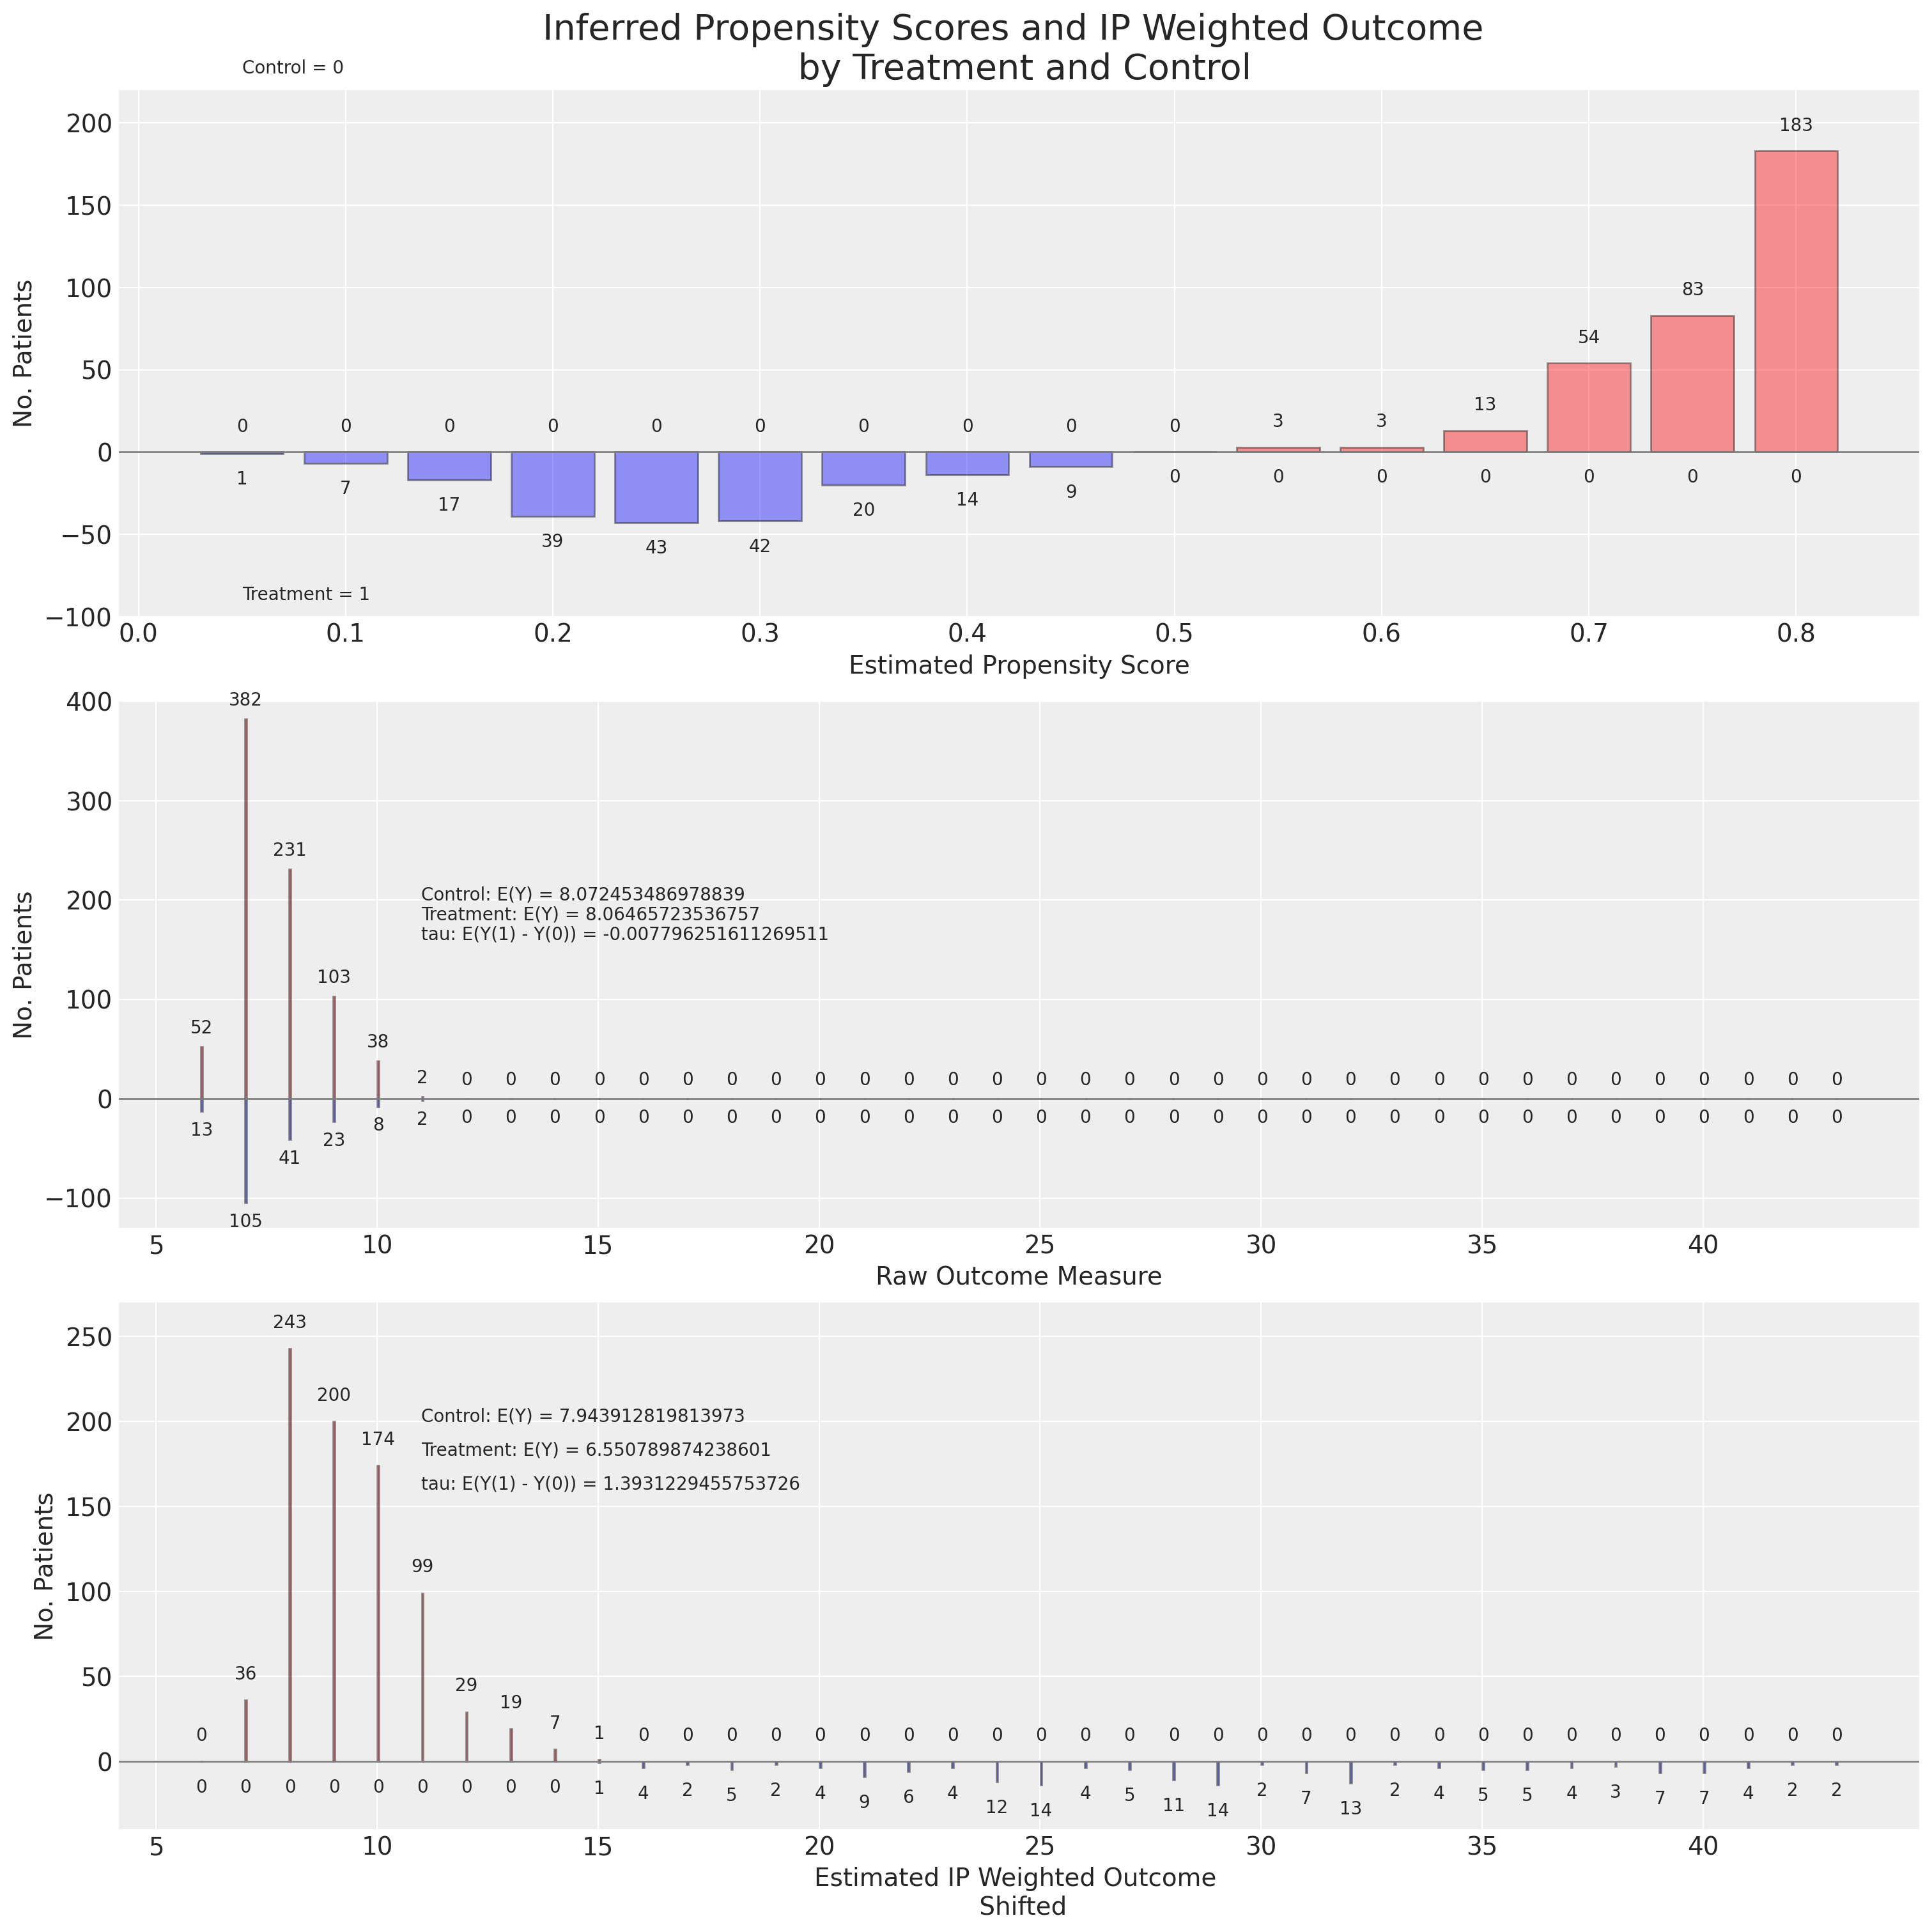

In [232]:
make_plot(
    X,
    idata_expend,
    ylims=[(-100, 220), (-40, 270), (-130, 400)],
    lower_bins=np.arange(6, 45, 1),
    text_pos=(11, 200),
)

In [140]:
qs = range(4000)
ate_dist = [get_ate(X, t, y, q, idata_expend) for q in qs]
ate_dist_df = pd.DataFrame(ate_dist, columns=["ATE", "E(Y(1))", "E(Y(0))"])
ate_dist_df.head()

ATE   E(Y(1))   E(Y(0))
0  0.864425  7.319687  8.184112
1  0.905942  7.296297  8.202239
2 -0.466379  8.419144  7.952766
3  0.083884  7.934437  8.018321
4 -0.137841  8.099963  7.962122

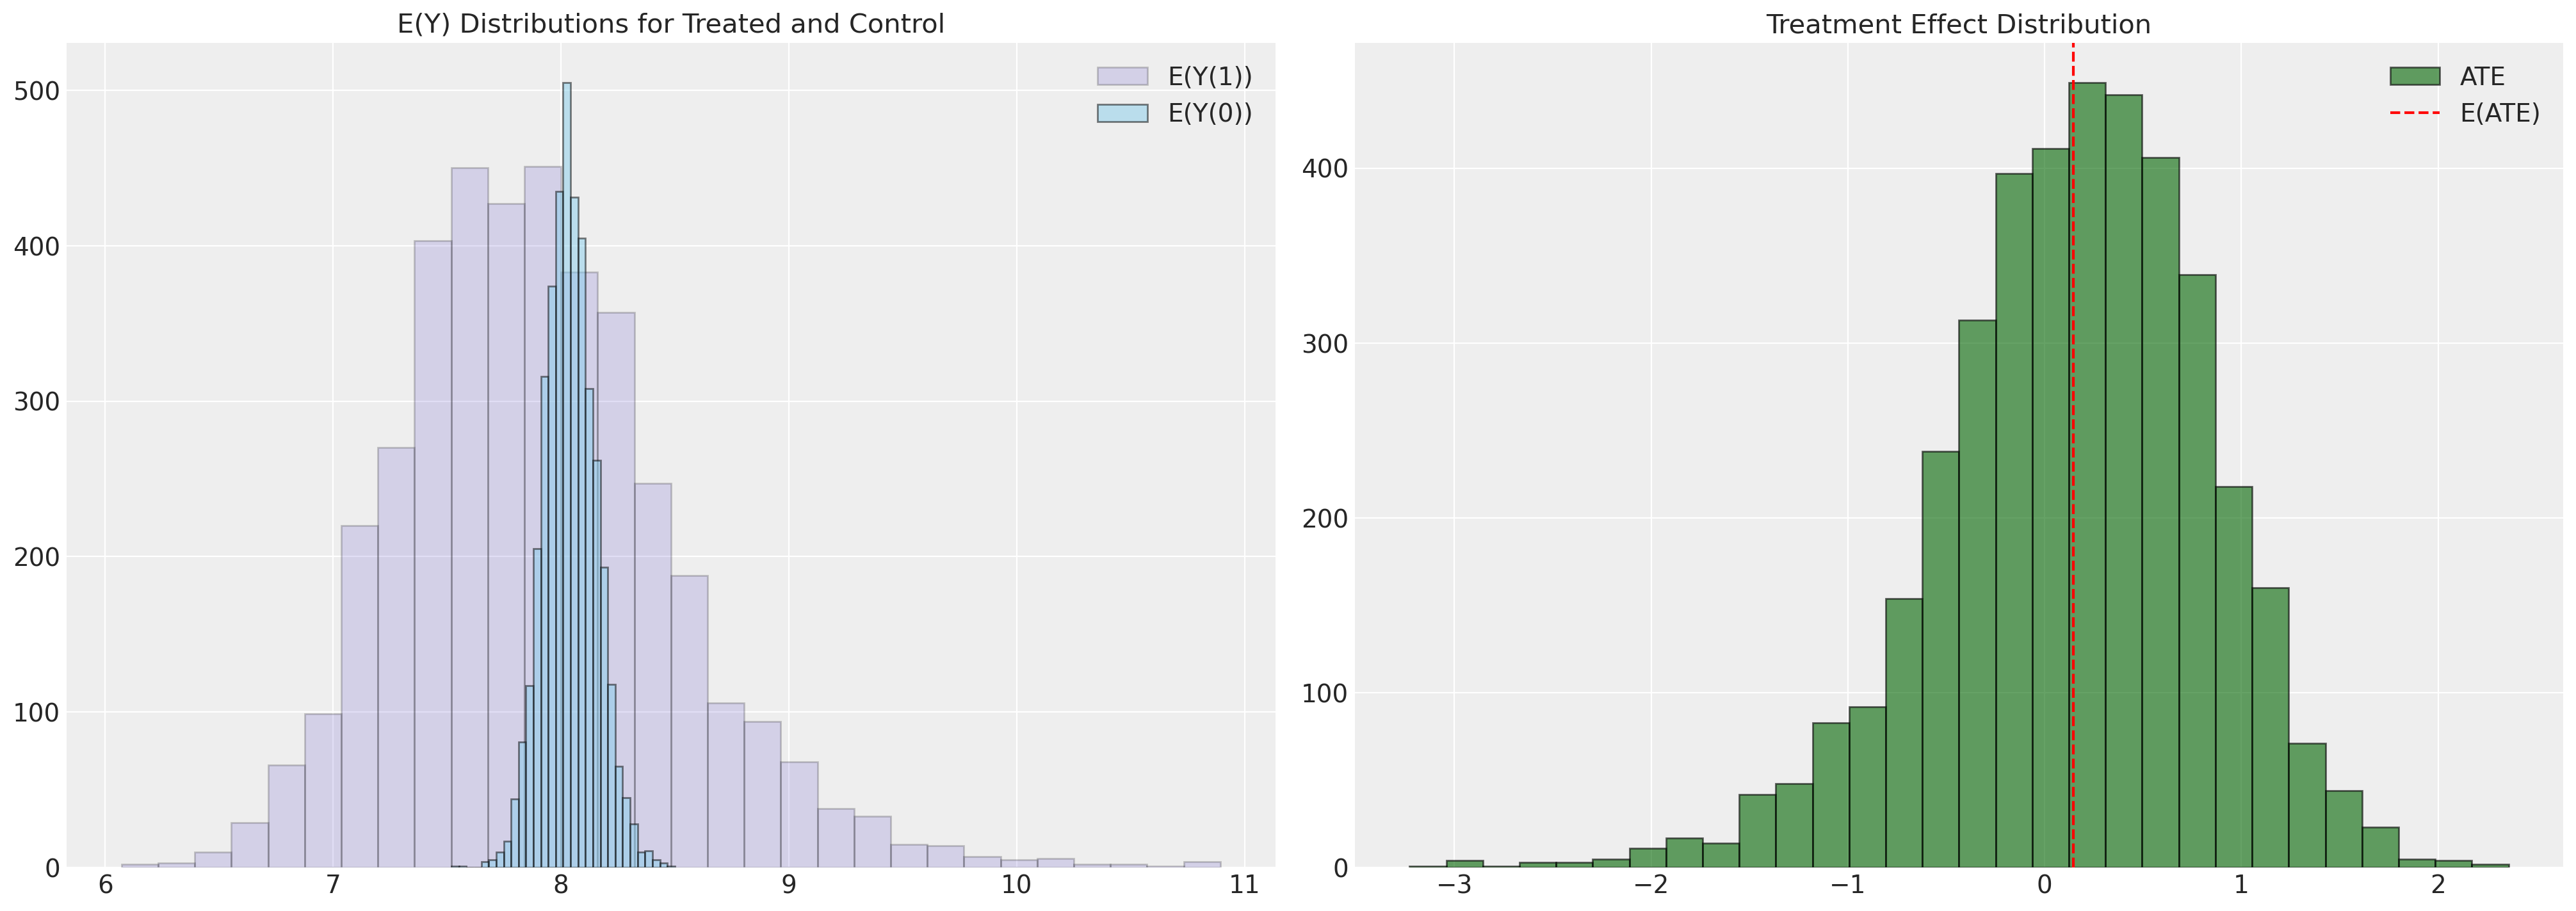

In [141]:
plot_ate(ate_dist_df)

### Quantile Models

In [151]:
dummies = pd.concat(
    [
        pd.get_dummies(df["seatbelt"], drop_first=True, prefix="seatbelt"),
        pd.get_dummies(df["marital"], drop_first=True, prefix="marital"),
        pd.get_dummies(df["race"], drop_first=True, prefix="race"),
        pd.get_dummies(df["sex"], drop_first=True, prefix="sex"),
        pd.get_dummies(df["phealth"], drop_first=True, prefix="phealth"),
    ],
    axis=1,
)
idx = df.sample(1000, random_state=100).index
X = pd.concat([df[["age", "bmi", "smoke"]], dummies], axis=1)
X = X.iloc[idx]
t = df.iloc[idx]["smoke"]
y = df.iloc[idx]["log_y"]
X

age   bmi  smoke  seatbelt_Always  seatbelt_Never  seatbelt_NoCar  \
2852    27  23.7      0                0               0               0   
13271   71  29.1      0                1               0               0   
6786    19  21.3      0                1               0               0   
15172   20  38.0      0                1               0               0   
10967   22  28.7      0                1               0               0   
...    ...   ...    ...              ...             ...             ...   
5404    30  35.6      0                1               0               0   
8665    80  22.0      0                1               0               0   
3726    49  32.9      0                1               0               0   
6075    49  34.2      0                1               0               0   
795     53  28.2      1                1               0               0   

       seatbelt_Seldom  seatbelt_Sometimes  marital_Married  \
2852                 0                   0                1   
13271                0                   0                0   
6786                 0                   0                0   
15172                0                   0                0   
10967                0                   0                1   
...                ...                 ...              ...   
5404                 0                   0                1   
8665                 0                   0                0   
3726                 0                   0                1   
6075                 0                   0                1   
795                  0                   0                1   

       marital_Separated  ...  race_Black  race_Indig  race_Multi  \
2852                   0  ...           0           0           0   
13271                  0  ...           1           0           0   
6786                   1  ...           0           0           0   
15172                  1  ...           1           0           0   
10967                  0  ...           0           0           0   
...                  ...  ...         ...         ...         ...   
5404                   0  ...           0           0           0   
8665                   0  ...           0           0           0   
3726                   0  ...           1           0           0   
6075                   0  ...           0           0           0   
795                    0  ...           0           0           0   

       race_PacificIslander  race_White  sex_Male  phealth_Fair  phealth_Good  \
2852                      0           1         1             0             0   
13271                     0           0         0             1             0   
6786                      0           1         0             0             0   
15172                     0           0         0             0             0   
10967                     0           1         0             0             0   
...                     ...         ...       ...           ...           ...   
5404                      0           1         1             0             1   
8665                      0           0         1             0             0   
3726                      0           0         1             0             1   
6075                      1           0         0             0             0   
795                       0           1         1             0             0   

       phealth_Poor  phealth_Very Good  
2852              0                  0  
13271             0                  0  
6786              0                  1  
15172             0                  1  
10967             0                  1  
...             ...                ...  
5404              0                  0  
8665              0                  0  
3726              0                  0  
6075              0                  1  
795               0                  0  

[1000 rows x 21 columns]

Sampling: [mu, obs, sigma]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/math.py:1102: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/math.py:1102: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/math.py:1102: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/math.py:1102: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tens

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


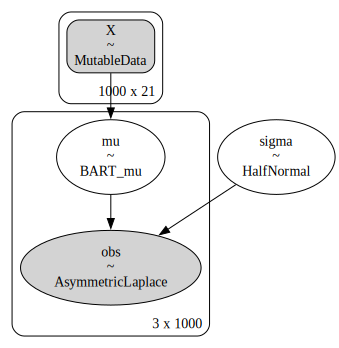

In [161]:
y_stack = np.stack([y] * 3)
quantiles = np.array([[0.9, 0.95, 0.975]]).T

with pm.Model() as model_q:
    X_data = pm.MutableData("X", X)
    mu = pmb.BART("mu", X_data, y, shape=(3, X_data.shape[0]))
    sigma = pm.HalfNormal("sigma", 1)
    obs = pm.AsymmetricLaplace("obs", mu=mu, b=sigma, q=quantiles, observed=y_stack)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())

pm.model_to_graphviz(model_q)

In [162]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

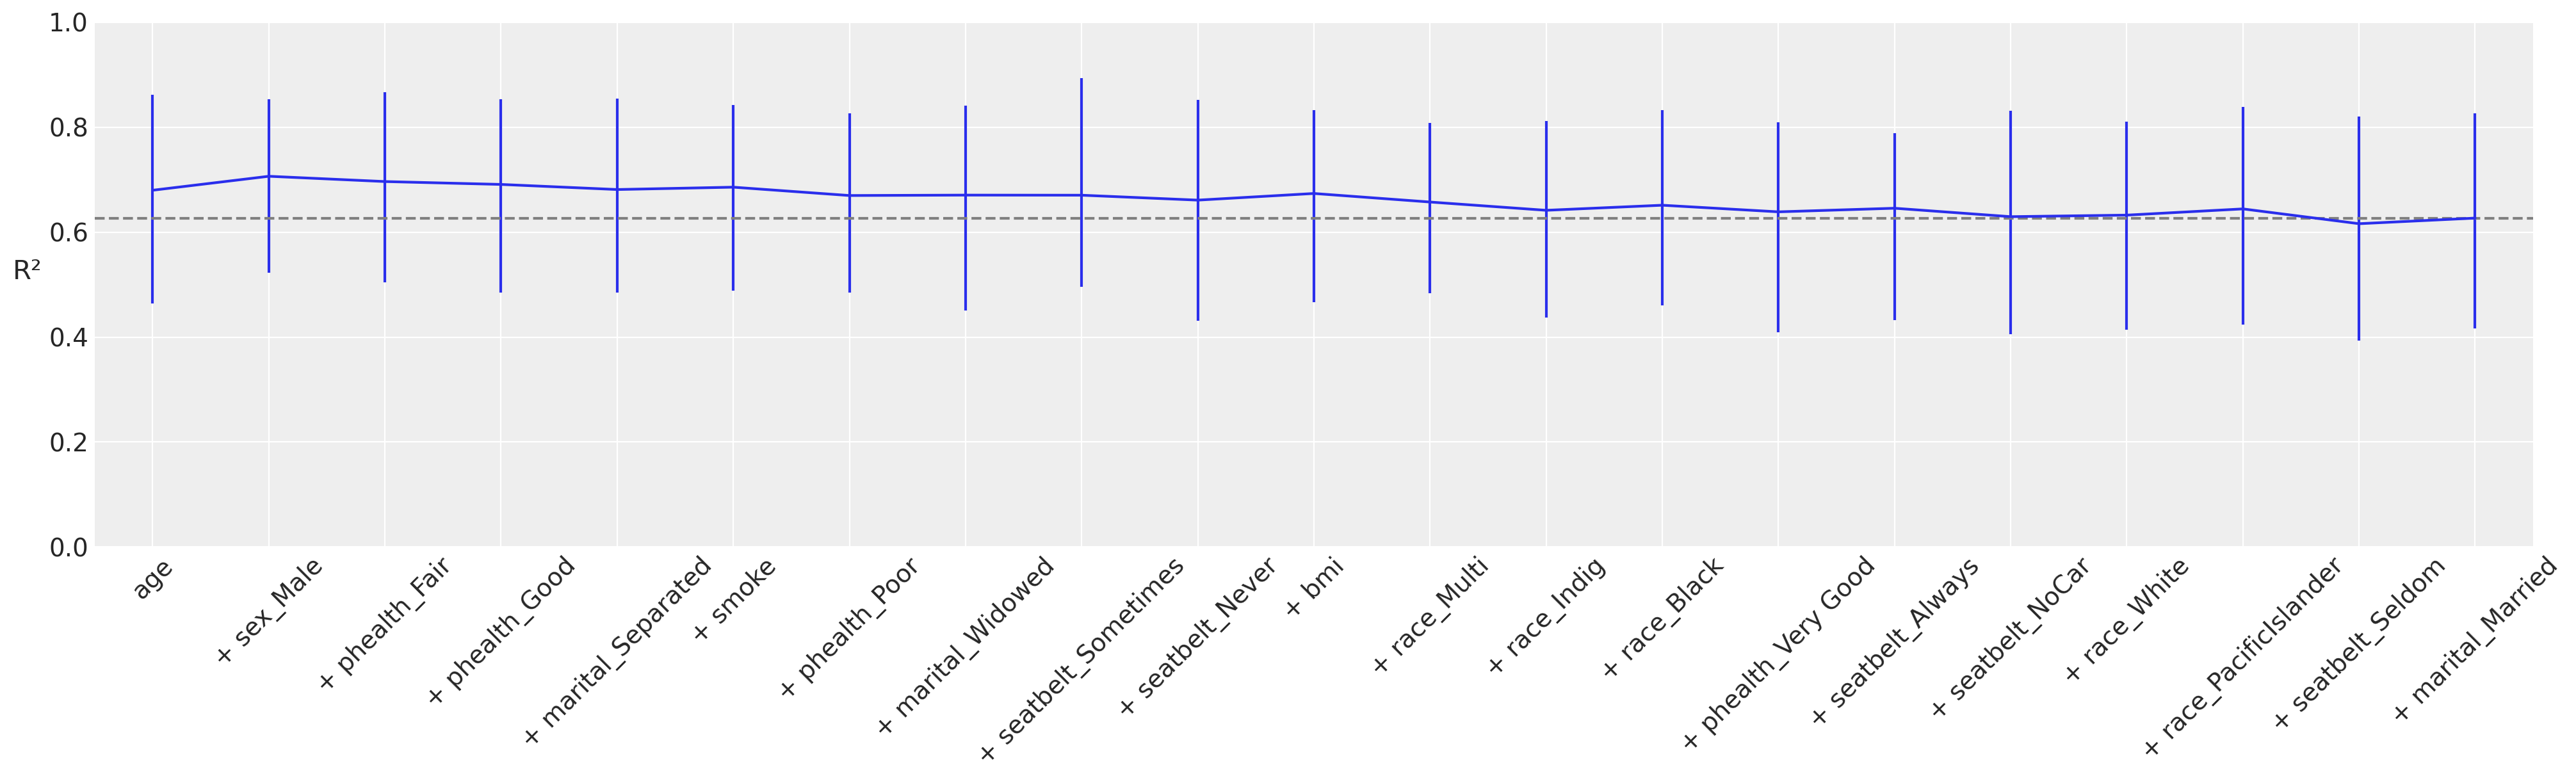

In [163]:
order, ax = pmb.plot_variable_importance(idata, bartrv=mu, X=X, figsize=(20, 6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

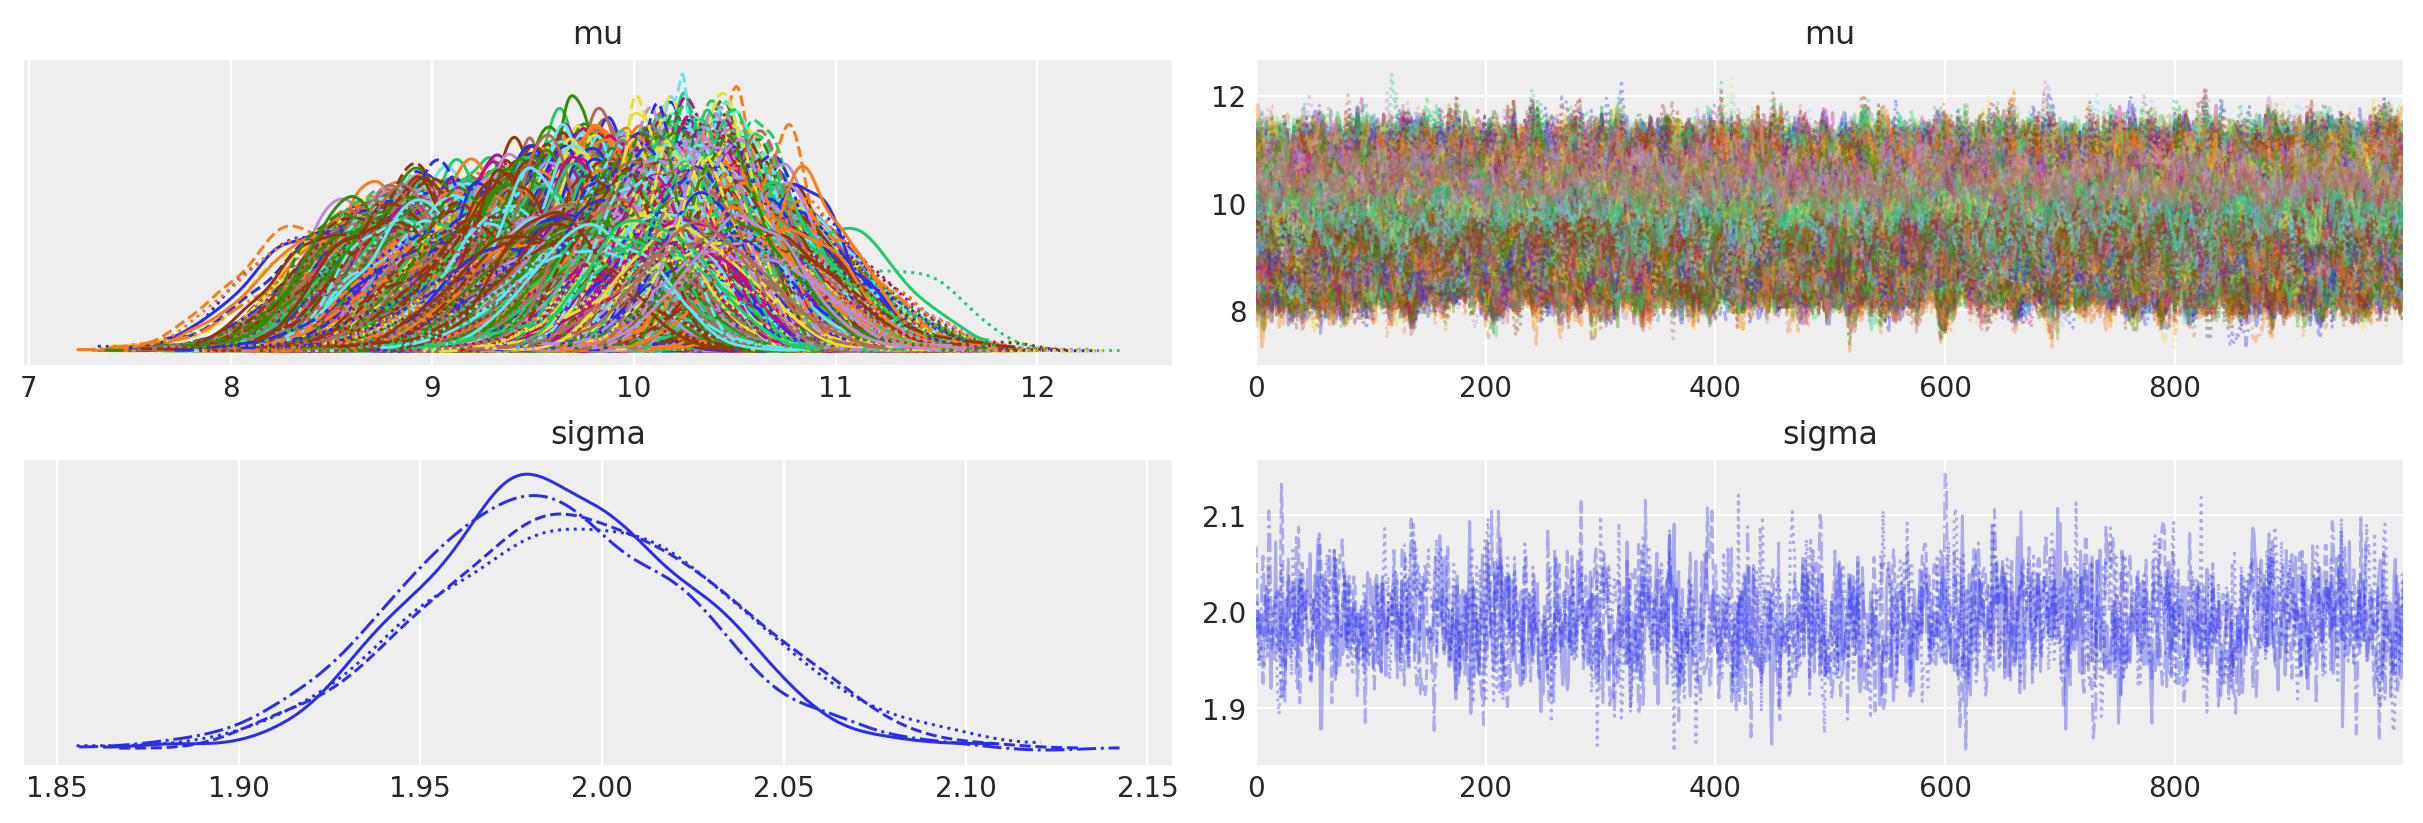

In [168]:
az.plot_trace(idata, var_names=["mu", "sigma"])

### Inferred Quantile Causal Effects

In [164]:
X["smoke"] = 1
with model_q:
    # update values of predictors:
    pm.set_data({"X": X})
    idata_smoke = pm.sample_posterior_predictive(idata)

idata_smoke

Sampling: [mu, obs]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [165]:
X["smoke"] = 0
with model_q:
    # update values of predictors:
    pm.set_data({"X": X})
    idata_non_smoke = pm.sample_posterior_predictive(idata)

idata_non_smoke

Sampling: [obs]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [166]:
smoke_quantiles = idata_smoke["posterior_predictive"].mean(dim=("chain", "draw", "obs_dim_3"))
nonsmoke_quantiles = idata_non_smoke["posterior_predictive"].mean(
    dim=("chain", "draw", "obs_dim_3")
)
nonsmoke_quantiles

<xarray.Dataset>
Dimensions:    (obs_dim_2: 3)
Coordinates:
  * obs_dim_2  (obs_dim_2) int64 0 1 2
Data variables:
    obs        (obs_dim_2) float64 8.0 7.737 7.159

In [167]:
diff = smoke_quantiles - nonsmoke_quantiles
diff

<xarray.Dataset>
Dimensions:    (obs_dim_2: 3)
Coordinates:
  * obs_dim_2  (obs_dim_2) int64 0 1 2
Data variables:
    obs        (obs_dim_2) float64 -0.7871 -0.8358 -0.8649

### Propensity Score Modelling



Sampling: [alpha, beta, delta, gamma, obs, tau]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.959933
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:09:43.900766
Transforming variables...


Sampling: [obs]


Transformation time =  0:00:01.079712


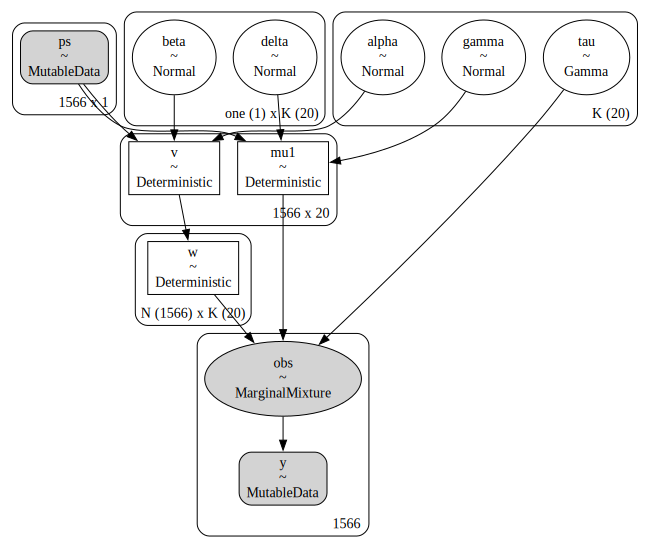

In [798]:
import pymc_bart as pmb
import pytensor.tensor as pt

p = X["ps"].values[:, np.newaxis]
K = 20
X = X.copy().reset_index(drop=True)
t = t.copy().reset_index(drop=True)
coords = {"N": np.arange(X.shape[0]), "K": np.arange(K) + 1, "one": [1]}


def norm_cdf(z):
    return 0.5 * (1 + pt.erf(z / np.sqrt(2)))


def stick_breaking(v):
    return v * pt.concatenate(
        [pt.ones_like(v[:, :1]), pt.extra_ops.cumprod(1 - v, axis=1)[:, :-1]], axis=1
    )


with pm.Model(coords=coords) as model_dpr:
    ps = pm.MutableData("ps", p)
    alpha = pm.Normal("alpha", 0.0, 5.0, dims="K")
    beta = pm.Normal("beta", 0.0, 1.0, dims=("one", "K"))
    v = pm.Deterministic("v", norm_cdf(alpha + pm.math.dot(ps, beta)))
    w = pm.Deterministic("w", stick_breaking(v), dims=("N", "K"))
    gamma = pm.Normal("gamma", 0.0, 5.0, dims="K")
    delta = pm.Normal("delta", 0.0, 1.0, dims=("one", "K"))
    mu1 = pm.Deterministic("mu1", gamma + pm.math.dot(ps, delta))
    tau = pm.Gamma("tau", 1.0, 1.0, dims="K")
    y_obs = pm.MutableData("y", y)
    obs = pm.NormalMixture("obs", w, mu1, tau=tau, observed=y_obs)

    idata_dpr = pm.sample_prior_predictive()
    idata_dpr.extend(pm.sample(500, nuts_sampler="numpyro", target_accept=0.99, chains=2))
    idata_dpr.extend(pm.sample_posterior_predictive(idata_dpr))

pm.model_to_graphviz(model_dpr)

## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in January 2024 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Jan 01 2024

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

arviz     : 0.15.1
matplotlib: 3.7.1
pymc      : 5.3.0
pandas    : 1.5.3
numpy     : 1.23.5

Watermark: 2.3.1



:::{include} ../page_footer.md
:::